In [390]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

from datetime import datetime




In [10]:
# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from scipy import stats
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
pd.options.mode.chained_assignment = None

In [485]:
NY_airbnb = pd.read_pickle("./NY_airbnb_clean.pkl")

In [361]:
NY_airbnb.columns

Index(['id', 'host_since', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'region', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'description_len',
       'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count', 'accomodates_level', 'bathroom_type',
       'Parking', 'Kitchen', 'TV', 'Wifi', 'amenities_count',
  

# Occupancy rate


This project will analyze the Airbnb listings and identify critical features that mostly affect the occupancy rate of a listing. The result of the analysis will help hosts in optimizing their listings and will increase the occupancy rates. Optimizing listings will eventually improve both hosts and guests experiences and yield higher retention.

The occupancy rates for each listing is estimated as a function of the average number of reviews per month and minimum required nights. Occupancy level is derived from occupancy rates and divide listings as high, average and low occupancy considering the following industry occupancy levels. 
-- The U.S. average occupancy rate is about 46.% by April, 2021.
-- An ideal occupancy rate for hotels is between 70% and 95%.




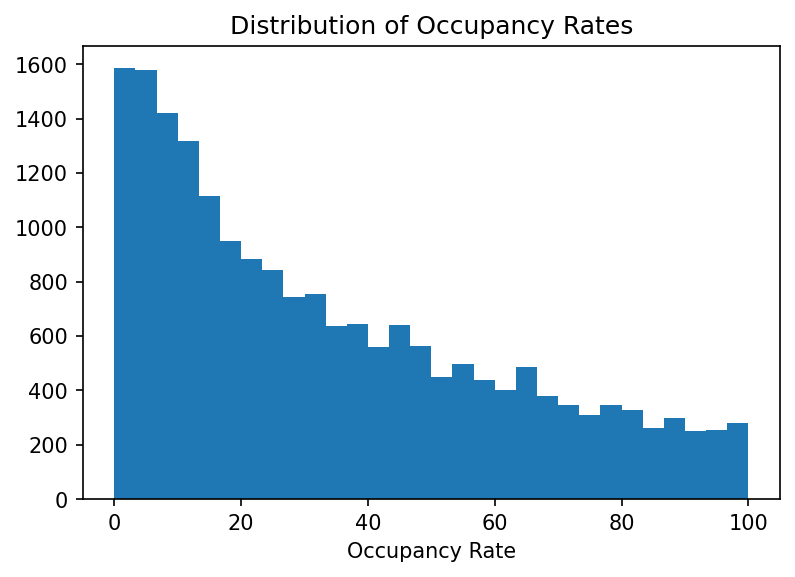

In [27]:
plt.figure(dpi=150)
plt.hist(NY_airbnb.occupancy_rate, bins=30, range= (0,100))
plt.title('Distribution of Occupancy Rates')
plt.xlabel('Occupancy Rate')

plt.savefig('occupancy_hist.png')

In [26]:
NY_airbnb.occupancy_rate.describe()

count    19573.000000
mean        34.641223
std         26.997818
min          0.109589
25%         11.178082
50%         27.397260
75%         53.150685
max         99.945205
Name: occupancy_rate, dtype: float64

In [29]:
print('90 percentile of occupancy rate', np.percentile(NY_airbnb.occupancy_rate,90))
print('95 percentile of occupancy rate', np.percentile(NY_airbnb.occupancy_rate,95))


90 percentile of occupancy rate 76.93150684931506
95 percentile of occupancy rate 88.37260273972579


In [31]:
mask1 = NY_airbnb.occupancy_rate > np.percentile(NY_airbnb.occupancy_rate,90)
mask2 = NY_airbnb.occupancy_rate > np.percentile(NY_airbnb.occupancy_rate,95)
#mask3 = NY_airbnb.occupancy_rate <= np.percentile(NY_airbnb.occupancy_rate,90) & NY_airbnb.occupancy_rate > np.percentile(NY_airbnb.occupancy_rate,70)

In [34]:
print('The number of listings with higher than 90% occupancy rate',NY_airbnb[mask1].shape[0])
print('The number of listings with higher than 95% occupancy rate',NY_airbnb[mask2].shape[0])

The number of listings with higher than 90% occupancy rate 1951
The number of listings with higher than 95% occupancy rate 979


In [362]:
NY_airbnb['occupancy_level'] = pd.cut(NY_airbnb.occupancy_rate, 
                               bins=[0, 46, 70, 100], 
                               labels=['low', 'average', 'high'], 
                               include_lowest=True)

In [57]:
NY_airbnb['occupancy_level'].value_counts()

low        13347
average     3553
high        2673
Name: occupancy_level, dtype: int64

low        13347
average     3553
high        2673
Name: occupancy_level, dtype: int64


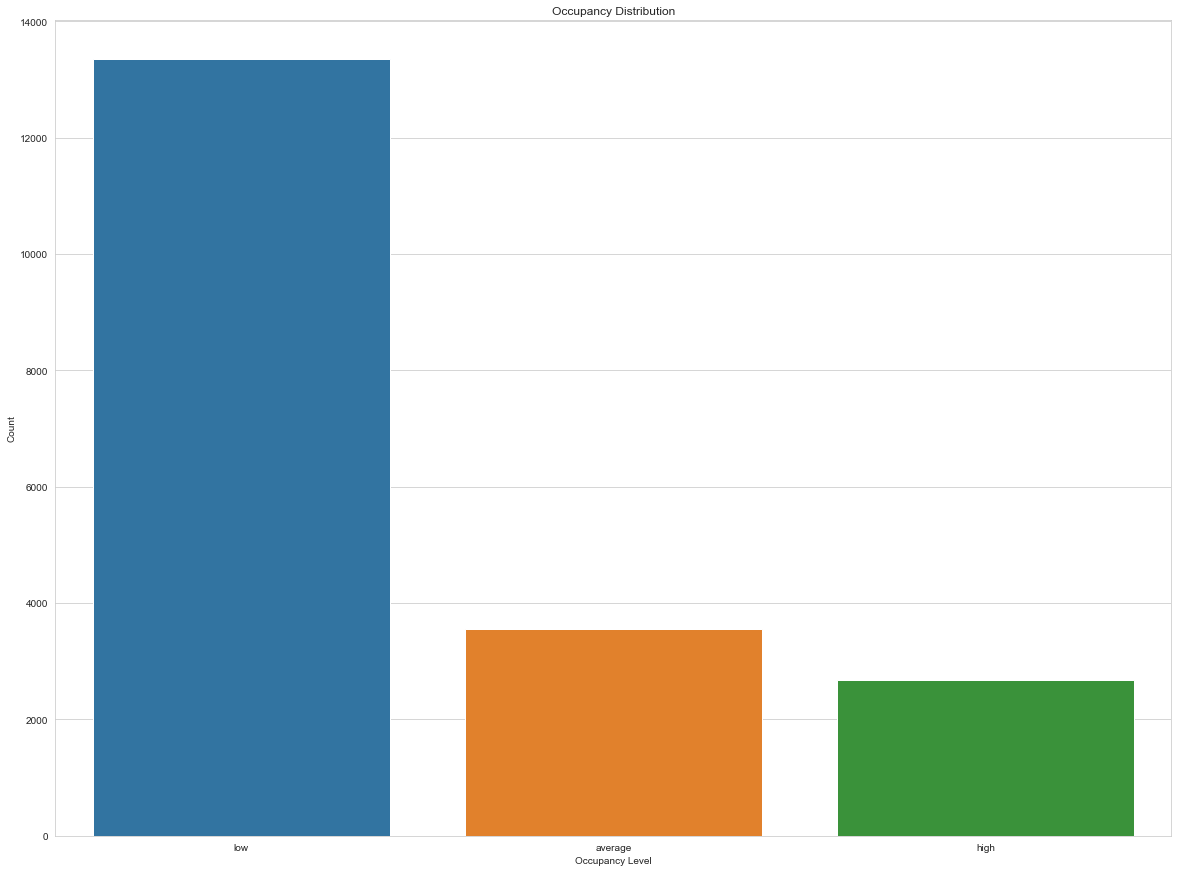

In [342]:
print(NY_airbnb.occupancy_level.value_counts())

#plt.figure(dpi=150)
plt = sns.countplot(x="occupancy_level", data =NY_airbnb)
plt.set(xlabel='Occupancy Level', ylabel='Count', title = 'Occupancy Distribution')
plt.figsize=(10,8)
plt.figure.savefig('occupancy_nominal.png')


# Classification evaluation metric

Precision is important to categorize the listings correctly. If hosts know, their listings would create high or low occupancy, they would act differently. For example, a host with a low predicted occupancy might invest in various sources and search methods to increase the occupancy rate. So, it is important to provide the right information to the host. 

On the other hand, recall is also relevant in this concept. Identifing a high occupancy listing as lower category causes additional costs to the listing host who aims to improve his listings occupancy as well as his profit and might affect adversely the host's revenue from the Airbnb platform. Eventually, this, false negatives, rises the host churn rate from the platform. 

The other point need to be considered before picking an evaluation metric is the nature of the target feature. The occupancy level is multiclass and imbalanced. As stated above, I will take a balanced approach between precision and recall with more weight to precision. So, I will use F1 beta metric to evaluate the model performance with an average option 'weighted' to account for label imbalance. As a secondary evaluation metric, I will use the balanced accuracy.

The model will be evaluated candidate models using repeated stratified k-fold cross-validation.

- Stratified means that each fold will aim to contain the same mixture of examples by class as the entire training dataset. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. I will use three repeats( link:)[https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/]



# EDA and Baseline model

In [373]:
listings = NY_airbnb[['id', 'host_since', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'region', 'room_type', 'accommodates','bedrooms',
       'beds', 'price', 'availability_365',
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'description_len', 'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count', 'accomodates_level', 'bathroom_type',
       'Parking', 'amenities_count',
       'short_term_rental', 'time_since_last_review_bin', 'occupancy_level']]

In [80]:
#listings['host_response_time'] = listings['host_response_time'].astype('category')

In [100]:
listings.shape # There are total 40 features to predict occupancy level

(19573, 38)

In [480]:
def get_pairplot_cols(df, first_col, last_col):
    sns.set_style("whitegrid", {'axes.grid' : False})
    #plt.figure()
    cols_to_plot = df.columns[first_col:last_col-1].tolist() + ['occupancy_level'] # explicitly add the column "top_listing" to your list of columns to plot
    sns.pairplot(df[cols_to_plot], hue ='occupancy_level')
   

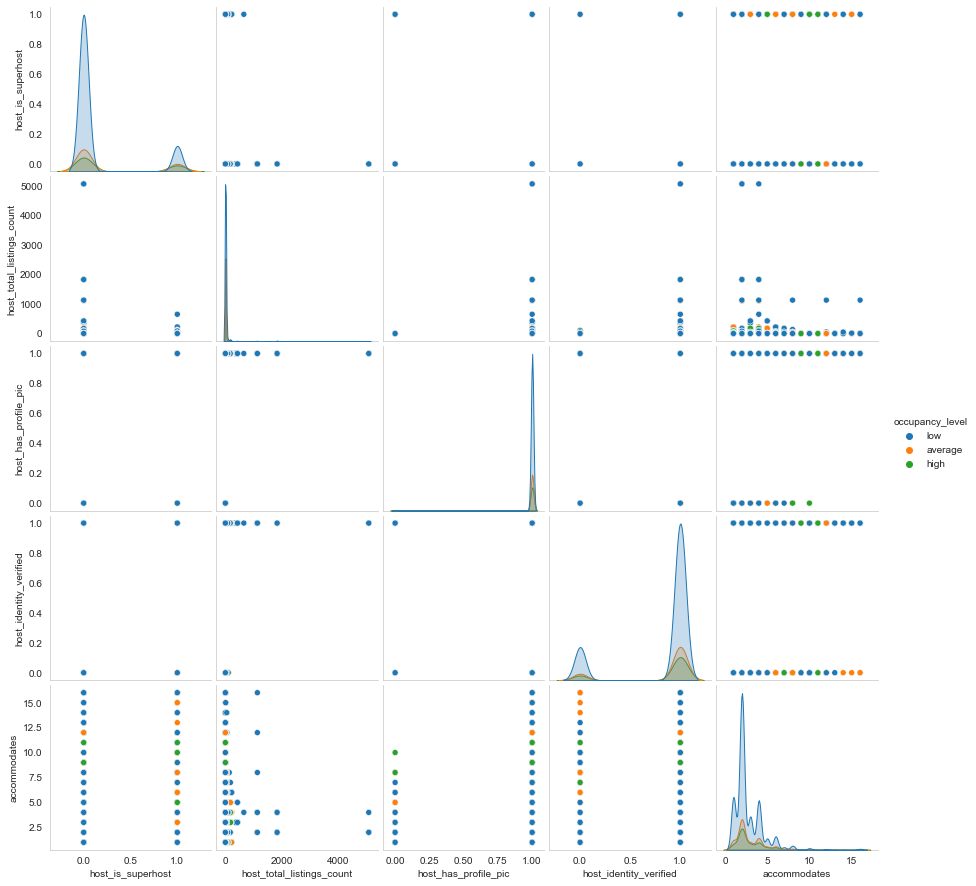

In [81]:
get_pairplot_cols(listings, 1,11)

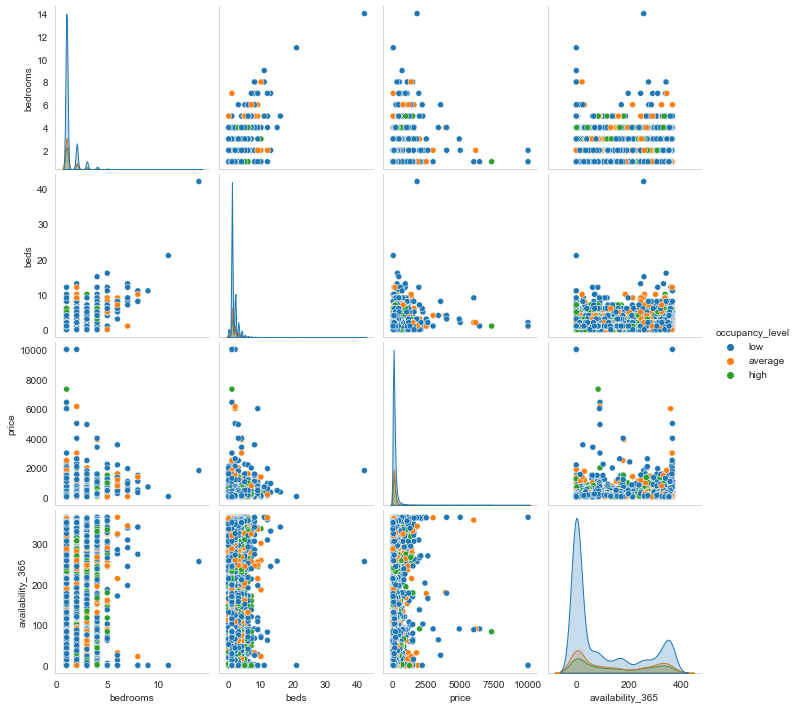

In [84]:
get_pairplot_cols(listings, 11,16)

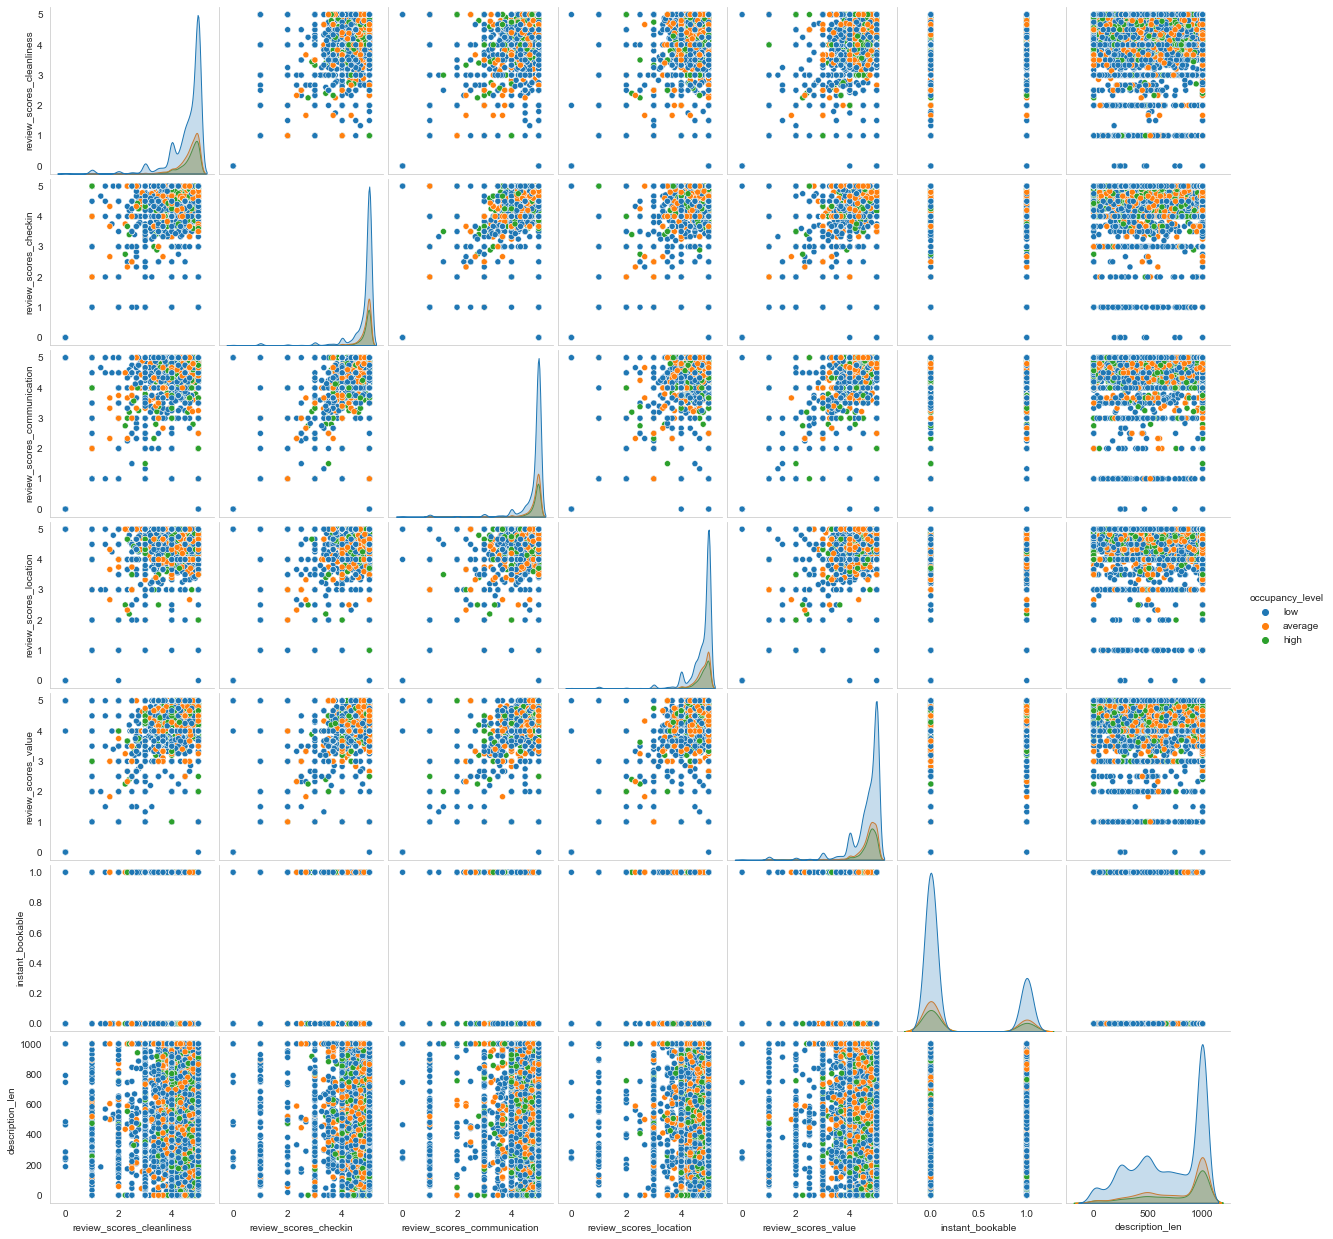

In [481]:
get_pairplot_cols(listings, 16,24)
plt.savefig('EDA2.png',dpi =150)

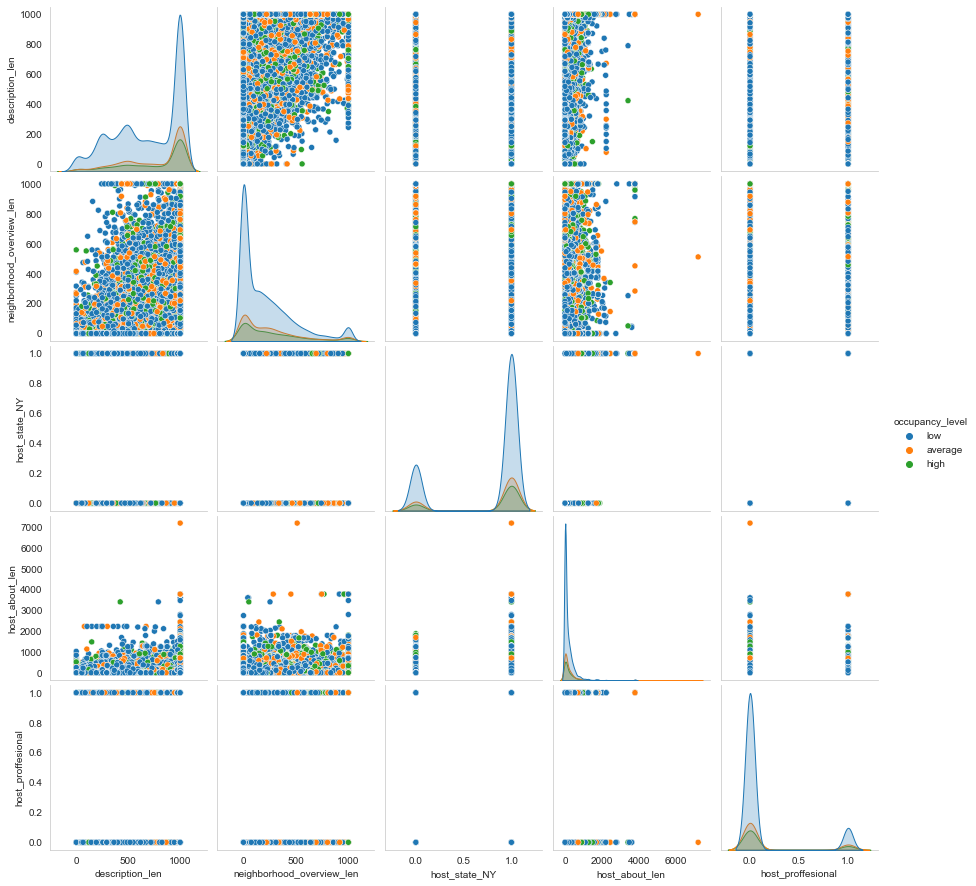

In [88]:
get_pairplot_cols(listings, 24,31)

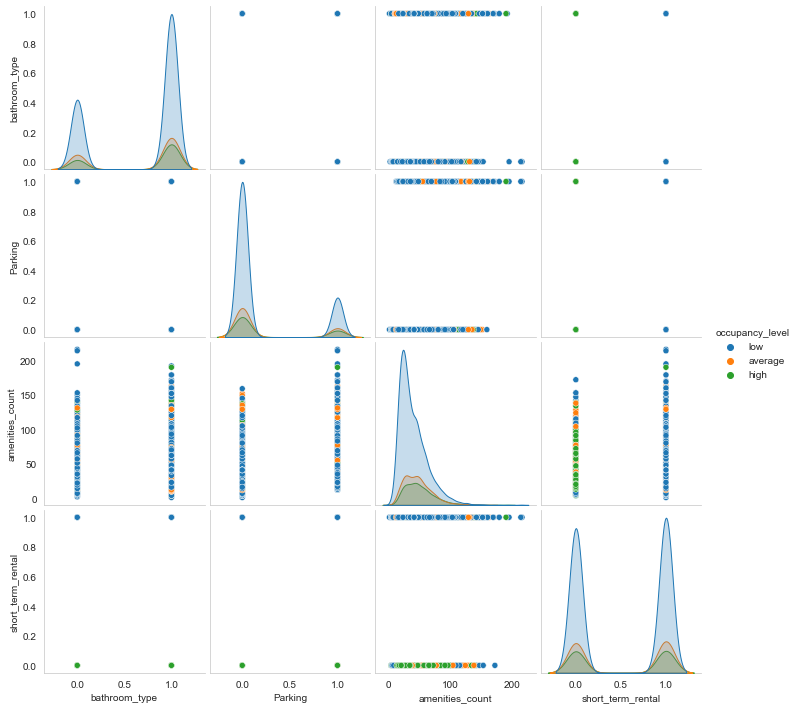

In [101]:
get_pairplot_cols(listings, 31,38)

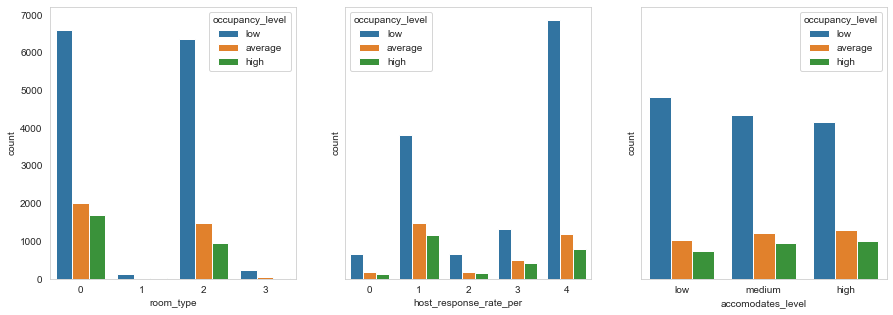

In [486]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.countplot(ax=axes[0],x =listings['room_type'], hue = listings.occupancy_level)
#axes[0].set_title()

sns.countplot(ax=axes[1],x =listings['host_response_rate_per'], hue = listings.occupancy_level)
#axes[1].set_title()

sns.countplot(ax=axes[2],x =listings['accomodates_level'], hue = listings.occupancy_level)


plt.savefig('EDA.png',dpi =150)

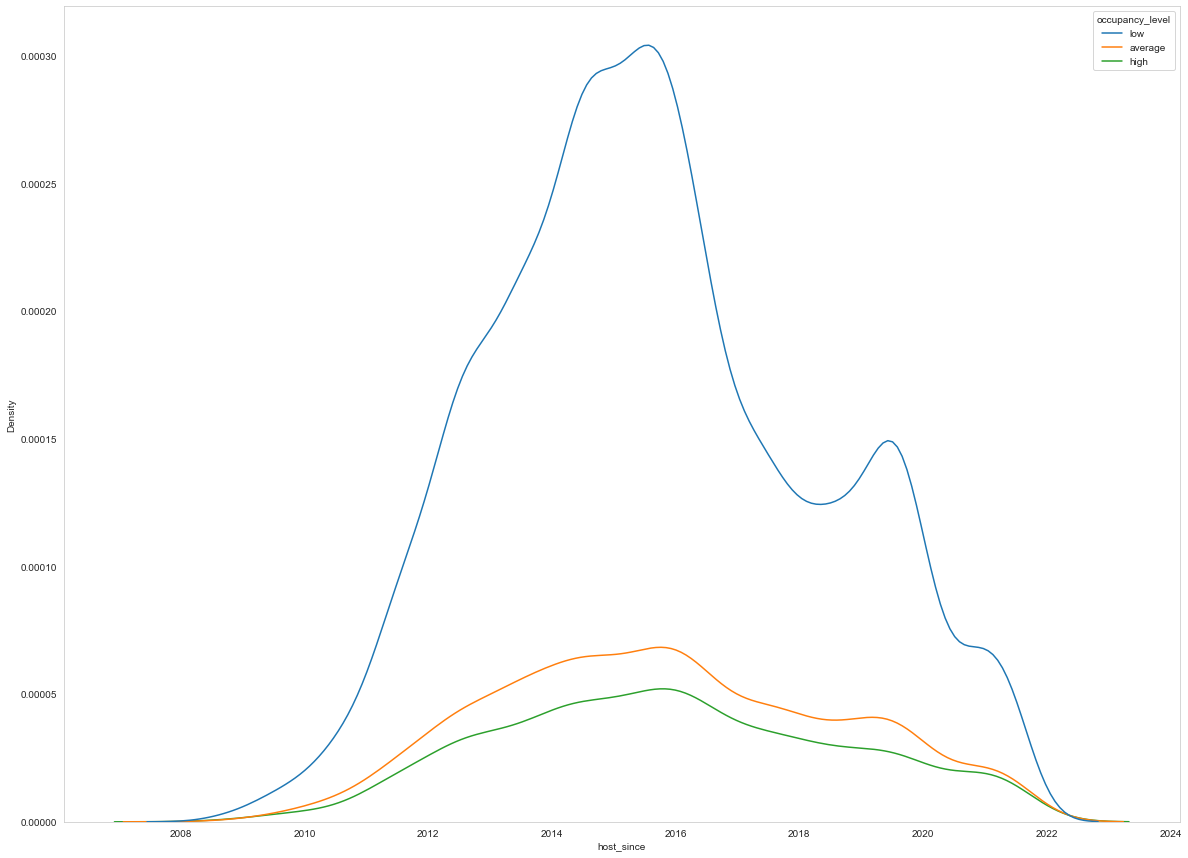

In [487]:
sns.kdeplot(data=listings, x='host_since',hue ='occupancy_level')
plt.savefig('EDA3.png', dpi = 150);

In [125]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask=mask[1:,:-1]
    corr = corr.iloc[1:,:-1].copy()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

C:\Users\12157\AppData\Local\Temp/ipykernel_16396/3293059936.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


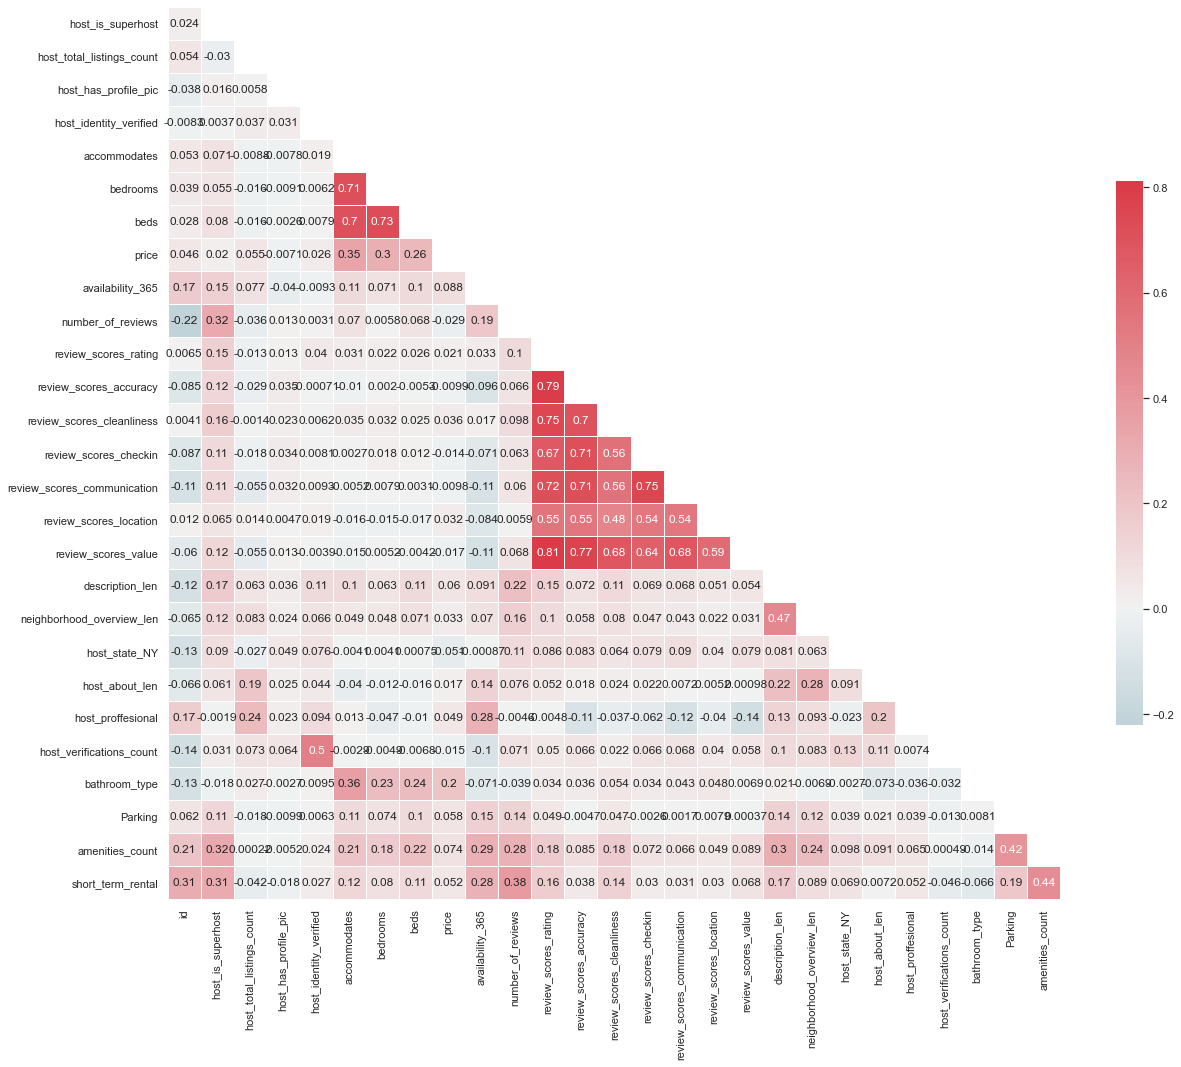

In [126]:
multi_collinearity_heatmap(listings, figsize=(20,20))

In [364]:
#beds and bedrooms are highly correlated, reduntant
listings.drop('beds',axis = 1, inplace =True )

# Baseline model

In [89]:
scaler = StandardScaler()



In [374]:
# label encode the target variable
y = listings['occupancy_level']
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
#class 0, average
#class 1, high
#class 2, low

Class=0, n=3553 (18.153%)
Class=2, n=13347 (68.191%)
Class=1, n=2673 (13.657%)


In [375]:
listings['host_since_ordinal'] = listings['host_since'].map(datetime.toordinal)


In [376]:
le =LabelEncoder()

listings['host_response_rate_per'] = LabelEncoder().fit_transform(listings['host_response_rate_per'])
listings['room_type'] = le.fit_transform(listings['room_type'])

listings['time_since_last_review_bin'] = le.fit_transform(listings['time_since_last_review_bin'])
listings['host_response_time']= le.fit_transform(listings['host_response_time'])


listings['instant_bookable'].replace({'f': 0, 't': 1}, inplace=True)

In [377]:
listings = pd.concat([listings, pd.get_dummies(listings['region'], drop_first = True)], axis=1)

In [382]:
listings['price_per'] = listings['price']/listings['accommodates']

In [291]:
# define models to test
def get_models():
    models, names = list(), list()
    # SVC
    models.append(SVC(gamma='auto'))
    names.append('SVC')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # Bagging
    models.append(BaggingClassifier(n_estimators=1000))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    # Naive
    #models.append(MultinomialNB())
    #names.append('Naive')
    return models, names




In [19]:
#evaluate a model with fbeta score
def evaluate_model(X, y, model):
    accuracy_balanced = make_scorer(balanced_accuracy_score)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=  accuracy_balanced, cv=cv, n_jobs=-1)
    return scores 

#evaluate a model with fbeta score
def evaluate_model_f(X, y, model):
    ftwo_scorer = make_scorer(fbeta_score, beta=0.75, average='weighted')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1)
    return scores    

In [ ]:
def feature_plot(classifier, features, top_features=2):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(12, 7))
    colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2*top_features), coef[top_coefficients], color=colors)
    features = np.array(features)
    plt.xticks(np.arange(1 +2*top_features), features[top_coefficients], rotation=45, ha='right')
    plt.savefig('svc_base.png',dpi =150)
    plt.show()

feature_plot(svc_base,features_names)

# Feature Engineering 

# Full model

In [488]:
NY_airbnb.columns

Index(['id', 'host_since', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'region', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'description_len',
       'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count', 'accomodates_level', 'bathroom_type',
       'Parking', 'Kitchen', 'TV', 'Wifi', 'amenities_count',
  

In [400]:
full_model =['host_since_ordinal', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'room_type', 'accommodates',
       'bedrooms', 'price_per', 'availability_365', 
       'instant_bookable', 'description_len',
       'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count',
       'Parking', 'amenities_count', 'short_term_rental',
       'time_since_last_review_bin','Brooklyn', 'Manhattan', 'Queens',
       'Staten Island']

In [484]:
len(full_model)

27

In [383]:
X = listings[['host_since_ordinal', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'room_type', 'accommodates',
       'bedrooms', 'price_per', 'availability_365', 
       'instant_bookable', 'description_len',
       'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count',
       'Parking', 'amenities_count', 'short_term_rental',
       'time_since_last_review_bin','Brooklyn', 'Manhattan', 'Queens',
       'Staten Island']]
y = listings['occupancy_level']

In [384]:
#split data and transform
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [385]:
# define models,  Full model with Fbeta
models, names = get_models()
results = list()

for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model_f(X_train_scaled, y_train, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores) ))

# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Full model, Fbeta')
plt.savefig('full.cv.png',dpi =150)
plt.show()

>SVC 0.561 (0.003)
>KNN 0.604 (0.005)
>BAG 0.615 (0.007)
>RF 0.602 (0.003)


TypeError: 'Text' object is not callable

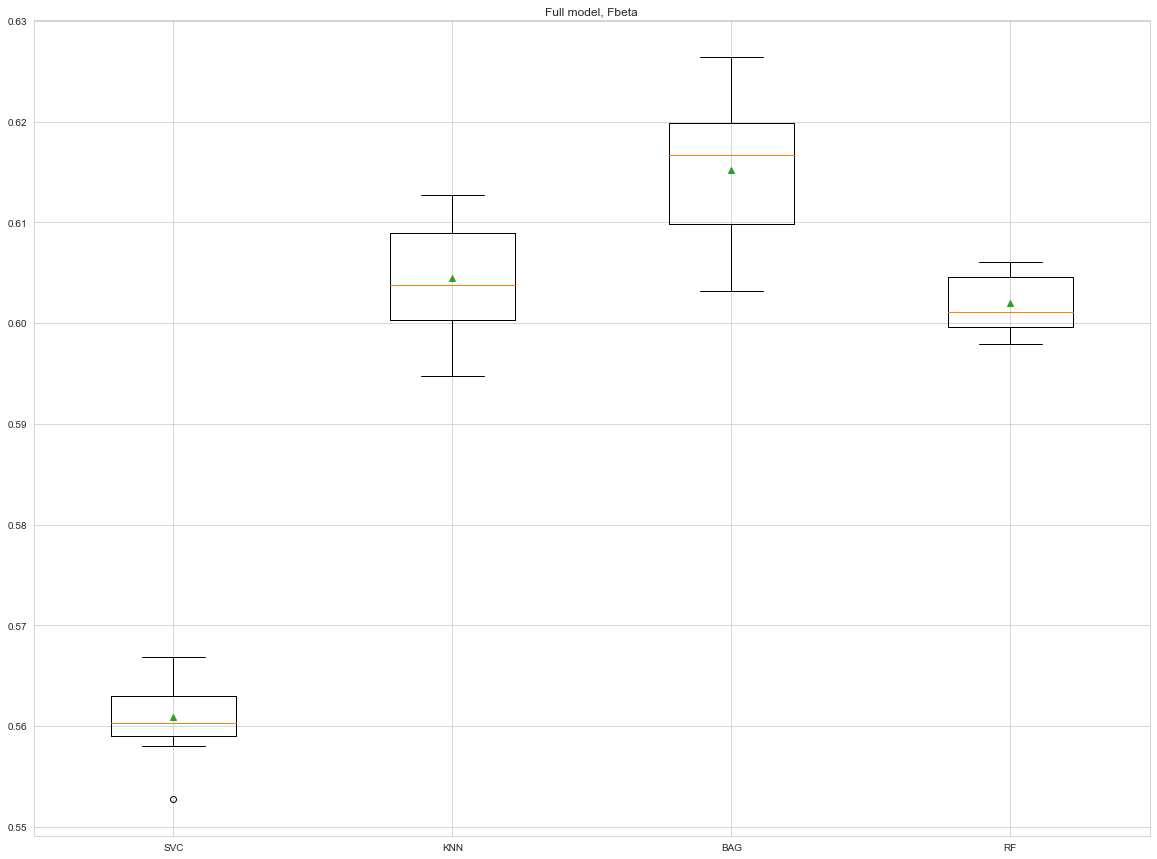

In [392]:
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Full model, Fbeta')
plt.savefig('full.cv.png',dpi =150)
plt.show()

>SVC 0.361 (0.003)
>KNN 0.411 (0.007)
>BAG 0.412 (0.008)
>RF 0.393 (0.004)


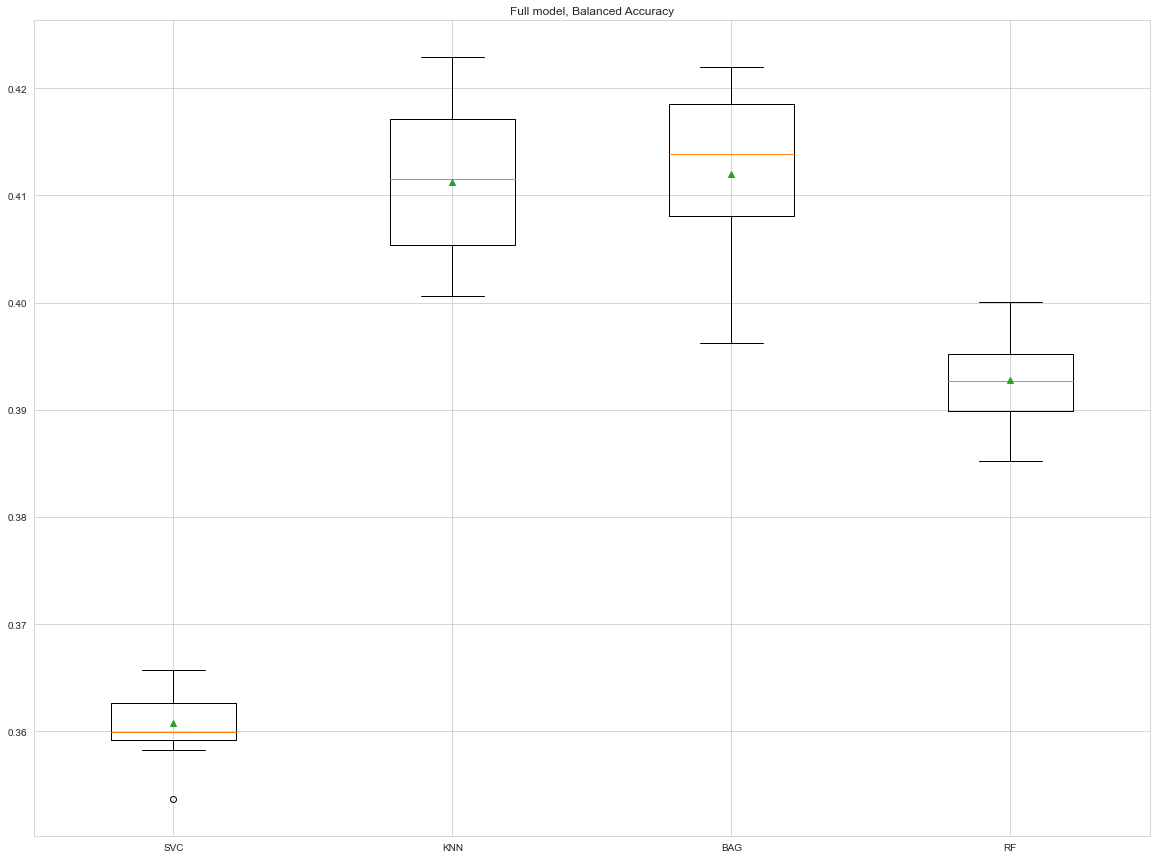

In [393]:
# define models, Full model with Balanced Accuracy
models, names = get_models()
results = list()

for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_train_scaled, y_train, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores) ))

# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Full model, Balanced Accuracy')
plt.savefig('full.cv.png',dpi =80)
plt.show()

Models with all features yield decent accuracies, fbeta values. Among different algorithms, kNN and Bagging are the most promising ones. I will move further with kNN and Random Forest since Random Forest is extension of bagging and with proper tuning it might perform better.

In [394]:
param_KNN = {
    'n_neighbors': (1,10, 100),
    'leaf_size': (1, 10),
    'weights': ('uniform', 'distance'),
}

In [395]:
#Grid Search for kNN

# First create the base model to tune
knn = KNeighborsClassifier()

knn_grid = GridSearchCV(estimator = knn, param_grid = param_KNN, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
knn_grid.fit(X_train_scaled, y_train)

results = knn_grid.cv_results_

# View best parameter
print('Best Score: ', knn_grid.best_score_)
print('Best Param: ', knn_grid.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Score:  0.595954604282538
Best Param:  {'leaf_size': 1, 'n_neighbors': 10, 'weights': 'uniform'}


In [396]:
results_df = pd.DataFrame.from_dict(results)
results_df[['params','mean_test_Fbeta','rank_test_Fbeta','mean_test_Balanced Accuracy','rank_test_Balanced Accuracy']].sort_values(by=['rank_test_Fbeta', 'rank_test_Balanced Accuracy'], ascending =True).head(5)

,params,mean_test_Fbeta,rank_test_Fbeta,mean_test_Balanced Accuracy,rank_test_Balanced Accuracy
2,"{'leaf_size': 1, 'n_neighbors': 10, 'weights':...",0.595955,1,0.389451,5
8,"{'leaf_size': 10, 'n_neighbors': 10, 'weights'...",0.595955,1,0.389451,5
3,"{'leaf_size': 1, 'n_neighbors': 10, 'weights':...",0.595479,3,0.388907,7
9,"{'leaf_size': 10, 'n_neighbors': 10, 'weights'...",0.595479,3,0.388907,7
0,"{'leaf_size': 1, 'n_neighbors': 1, 'weights': ...",0.578430,5,0.400001,1


kNN n =10 | Full model Fbeta score:  0.604  	
kNN n= 10 | Full model Balanced Accuracy beta score:  0.397  	


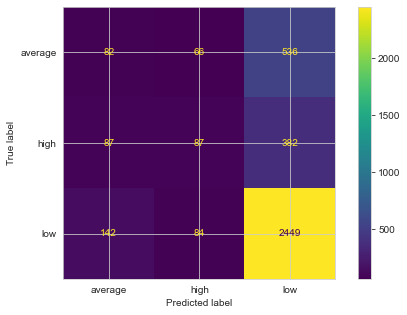

In [397]:
#kNN model with selected params, full model
kNN_full = KNeighborsClassifier(leaf_size= 1,n_neighbors= 10, weights= 'uniform')

kNN_full.fit(X_train_scaled, y_train)

#prediction on testing data
kNN_full_pred = kNN_full.predict(X_test_scaled)

#performance score of the model, fbeta
kNN_full_fbeta = fbeta_score(y_test, kNN_full_pred, beta=0.75, average='weighted')
kNN_full_accuracy = balanced_accuracy_score(y_test, kNN_full_pred)

print('kNN n =10 | Full model Fbeta score:  %.3f  \t' % kNN_full_fbeta)
print('kNN n= 10 | Full model Balanced Accuracy beta score:  %.3f  \t' % kNN_full_accuracy)


# Confusion matrix 
kNN_full_confusion = confusion_matrix(y_test, kNN_full_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, kNN_full_pred),
    display_labels=["average", "high","low"],
)

cmp.plot(ax=ax)
plt.savefig('kNN_full.conf.png',dpi =150)
plt.show();





In [411]:
#Grid Search for Random Forest

# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
rf_grid.fit(X_train_scaled, y_base_train)

results = rf_grid.cv_results_

# View best parameter
print('Best Score: ', rf_grid.best_score_)
print('Best Param: ', rf_grid.best_params_)



Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Score:  0.6371252823227186
Best Param:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


Random Forest  | Full F1 beta score:  0.631  	
Random Forest  | Full Balanced Accuracy score:  0.455  	


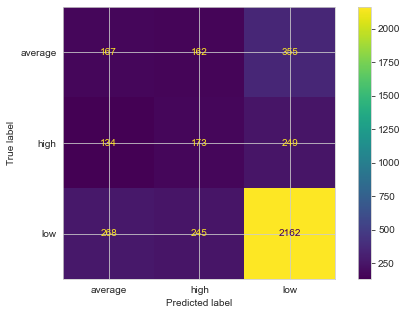

In [412]:
#Random Forest model with the selected params
rf_full = RandomForestClassifier(max_depth = None, max_features= 'auto',min_samples_leaf = 5, 
                                       min_samples_split= 2, n_estimators=100,class_weight='balanced')
rf_full.fit(X_train_scaled, y_train)

#prediction on testing data
rf_full_pred = rf_full.predict(X_test_scaled)

#performance score of the model, fbeta
rf_full_fbeta = fbeta_score(y_test, rf_full_pred, beta=0.75, average='weighted')
rf_full_accuracy = balanced_accuracy_score(y_test, rf_full_pred)

print('Random Forest  | Full F1 beta score:  %.3f  \t' % rf_full_fbeta)
print('Random Forest  | Full Balanced Accuracy score:  %.3f  \t' % rf_full_accuracy)


# Confusion matrix 
rf_full_confusion = confusion_matrix(y_test, rf_full_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, rf_full_pred),
    display_labels=["average", "high","low"],
)

cmp.plot(ax=ax)
plt.savefig('rf_full_conf.png',dpi =150)
plt.show();




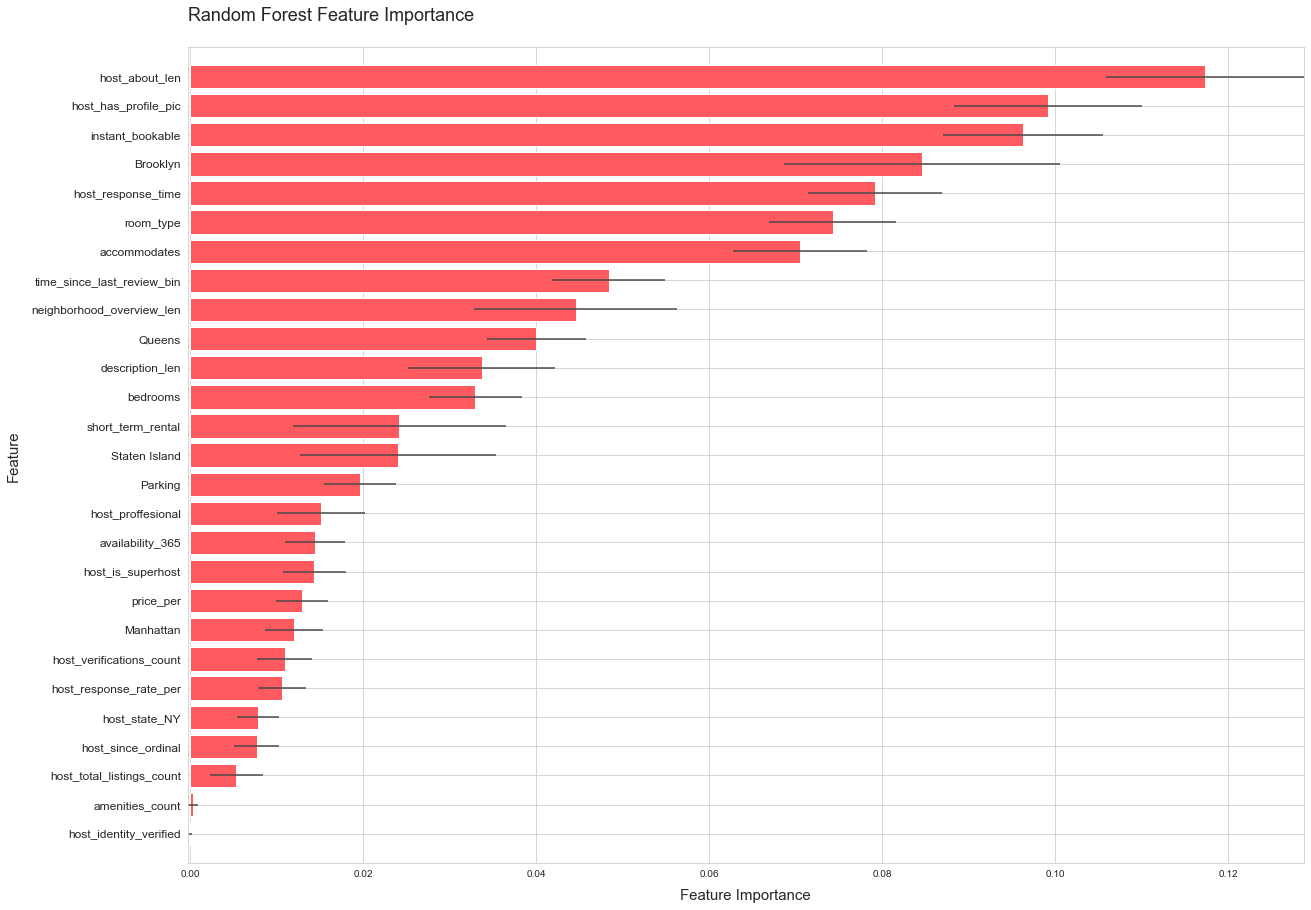

In [413]:
# compute feature importance and std
importances = rf_full.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_full.estimators_],
             axis=0)
indices = np.argsort(importances)

feature_list = [full_model[indices[f]] for f in range(X.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("Random Forest Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X_test.shape[1]), importances[indices],
       color = '#FF5A5F',ecolor ='#484848', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X_test.shape[1]])
plt.savefig('rf_full_feature.png',dpi =150)

plt.show()





C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoost | Full Fbeta score:  0.600  	
XGBoost | Full Balanced Accuracy score:  0.467  	


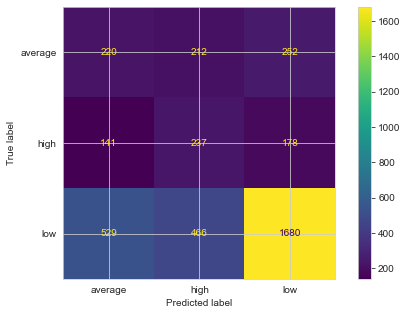

In [467]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train)



xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=1000, learning_rate=0.1, 
                          max_depth=4, subsample=0.8,  verbosity=1)
eval_set=[(X_train_scaled,y_train),(X_test_scaled,y_test)] #tracking train/validation error as we go
xgb_fit = xgb_model.fit( 
                        X_train_scaled, y_train, 
                        sample_weight = classes_weights, early_stopping_rounds = 50,eval_metric = 'merror',
                        eval_set = eval_set, verbose = False)

xgb_preds = xgb_model.predict(X_test_scaled, ntree_limit=xgb_model.best_ntree_limit)
    
# compute metric of interest
xgb_fbeta = fbeta_score(y_test, xgb_preds, beta=0.75, average='weighted') 
xgb_accuracy =  balanced_accuracy_score(y_test,  xgb_preds)

print('XGBoost | Full Fbeta score:  %.3f  \t' % xgb_fbeta)
print('XGBoost | Full Balanced Accuracy score:  %.3f  \t' % xgb_accuracy)

# Confusion matrix 
xgb2_confusion = confusion_matrix(y_test, xgb2_preds)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, xgb2_preds),
    display_labels=["average",  "high","low"],
)

cmp.plot(ax=ax)
plt.savefig('xgbfull_conf.png',dpi =150)
plt.show()




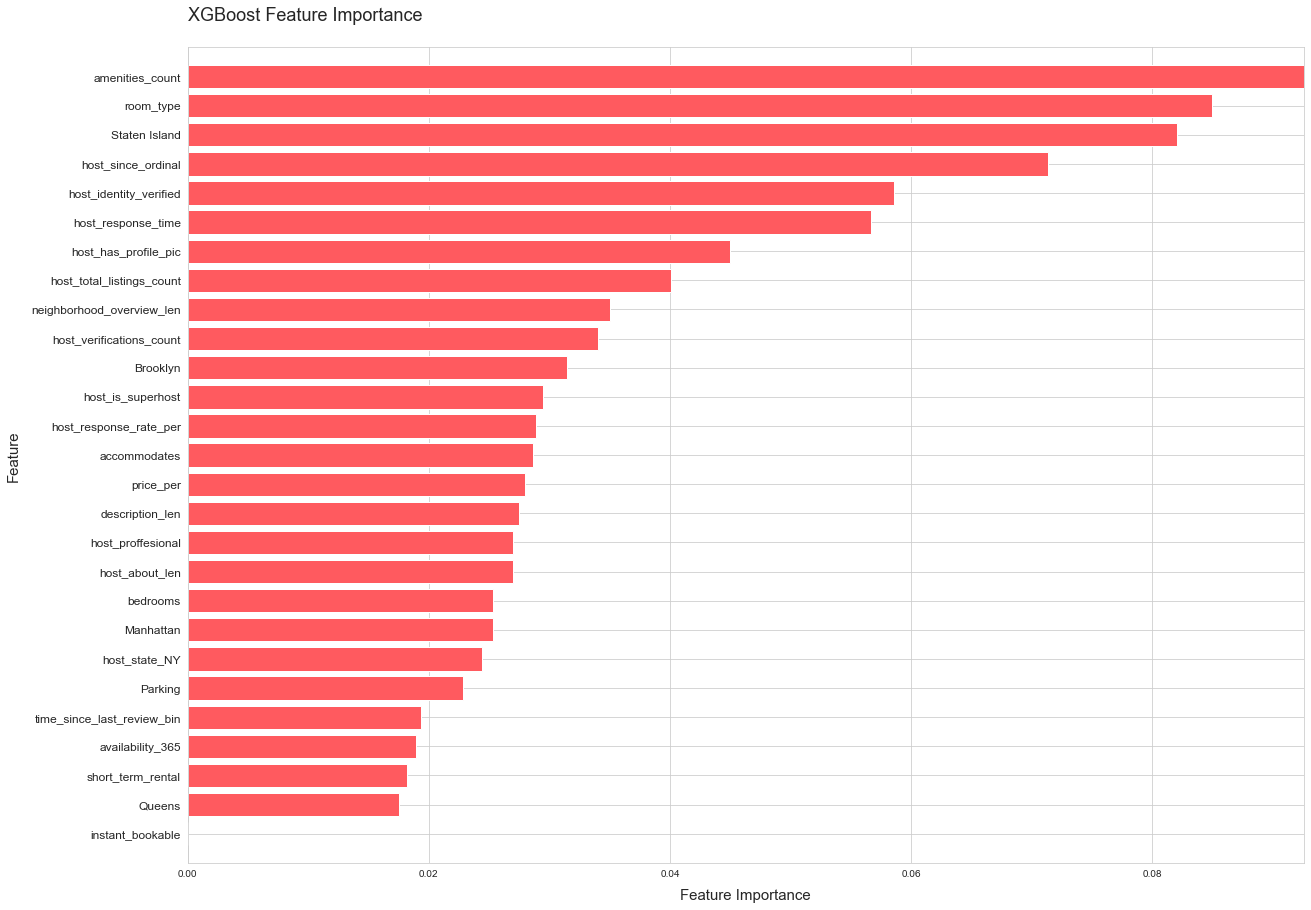

In [405]:
# compute feature importance and std
importances_xgb = xgb_model.feature_importances_

indices = np.argsort(importances_xgb)

feature_list = [full_model[indices[f]] for f in range(X.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("XGBoost Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X_test.shape[1]), importances_xgb[indices],
       color = '#FF5A5F',ecolor ='#484848', align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X_test.shape[1]])
plt.savefig('xgboost_feature.png',dpi =150)

plt.show()


In [406]:
importance_df_xgb = pd.DataFrame(importances_xgb, index=ff, 
                      columns=["Importance"])
importance_df_xgb.sort_values(by= 'Importance', ascending=False)

,Importance
amenities_count,0.092576
room_type,0.084967
Staten Island,0.082066
host_since_ordinal,0.071379
host_identity_verified,0.058557
host_response_time,0.056672
host_has_profile_pic,0.044989
host_total_listings_count,0.040100
neighborhood_overview_len,0.035000
host_verifications_count,0.034022


In [415]:
#combined = pd.concat([importance_df_rf,importance_df_xgb], axis=1)
#combined['total']= combined.iloc[:,0]+combined.iloc[:,1]
#combined.sort_values(by= 'total', ascending =False)

In [417]:
#reduced features based on the feature importance
features2= ['host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'room_type', 'accommodates',
       'bedrooms', 'price_per', 'availability_365', 
       'instant_bookable', 'description_len',
       'neighborhood_overview_len',
       'host_response_rate_per', 'host_proffesional',
       'Parking', 'amenities_count', 
       'time_since_last_review_bin','Brooklyn', 'Manhattan',
       'Staten Island']
X2 = listings[features2]

#split data and transform
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=42)


X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)



In [418]:
#Grid Search for kNN

# First create the base model to tune
knn2 = KNeighborsClassifier()

knn2_grid = GridSearchCV(estimator = knn, param_grid = param_KNN, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
knn2_grid.fit(X2_train_scaled, y_train)

results = knn2_grid.cv_results_

# View best parameter
print('Best Score: ', knn2_grid.best_score_)
print('Best Param: ', knn2_grid.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Score:  0.5883453041153395
Best Param:  {'leaf_size': 1, 'n_neighbors': 10, 'weights': 'uniform'}


kNN n =10 | Fbeta score:  0.596  	
kNN n= 10 | Balanced Accuracy beta score:  0.388  	


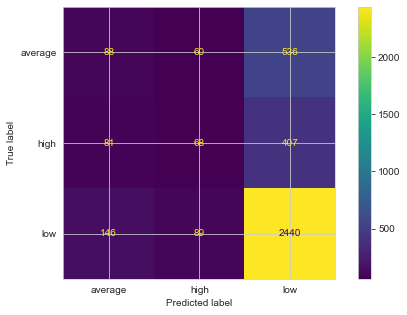

In [419]:
#kNN model with selected params
kNN2 = KNeighborsClassifier(leaf_size= 1,n_neighbors= 10, weights= 'uniform')

kNN2.fit(X2_train_scaled, y_train)

#prediction on testing data
kNN2_pred = kNN2.predict(X2_test_scaled)

#performance score of the model, fbeta
kNN2_fbeta = fbeta_score(y_test, kNN2_pred, beta=0.75, average='weighted')
kNN2_accuracy = balanced_accuracy_score(y_test, kNN2_pred)

print('kNN n =10 | Fbeta score:  %.3f  \t' % kNN2_fbeta)
print('kNN n= 10 | Balanced Accuracy beta score:  %.3f  \t' % kNN2_accuracy)


# Confusion matrix 
kNN2_confusion = confusion_matrix(y_test, kNN2_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, kNN2_pred),
    display_labels=["average", "high", "low"],
)

cmp.plot(ax=ax)
plt.savefig('kNN2.conf.png',dpi =150)
plt.show();


In [420]:

#Grid Search for Random Forest

# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
rf_grid.fit(X2_train_scaled, y_train)

results = rf_grid.cv_results_

# View best parameter
print('Best Score: ', rf_grid.best_score_)
print('Best Param: ', rf_grid.best_params_)



Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Score:  0.6200620664410609
Best Param:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


Random Forest2  | Fbeta score:  0.607  	
Random Forest2  | Balanced Accuracy score:  0.425  	


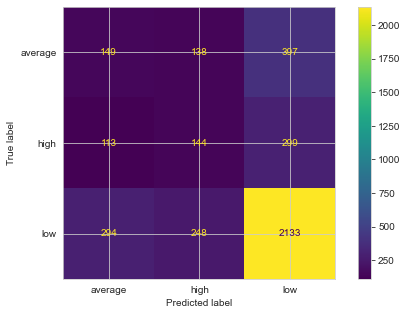

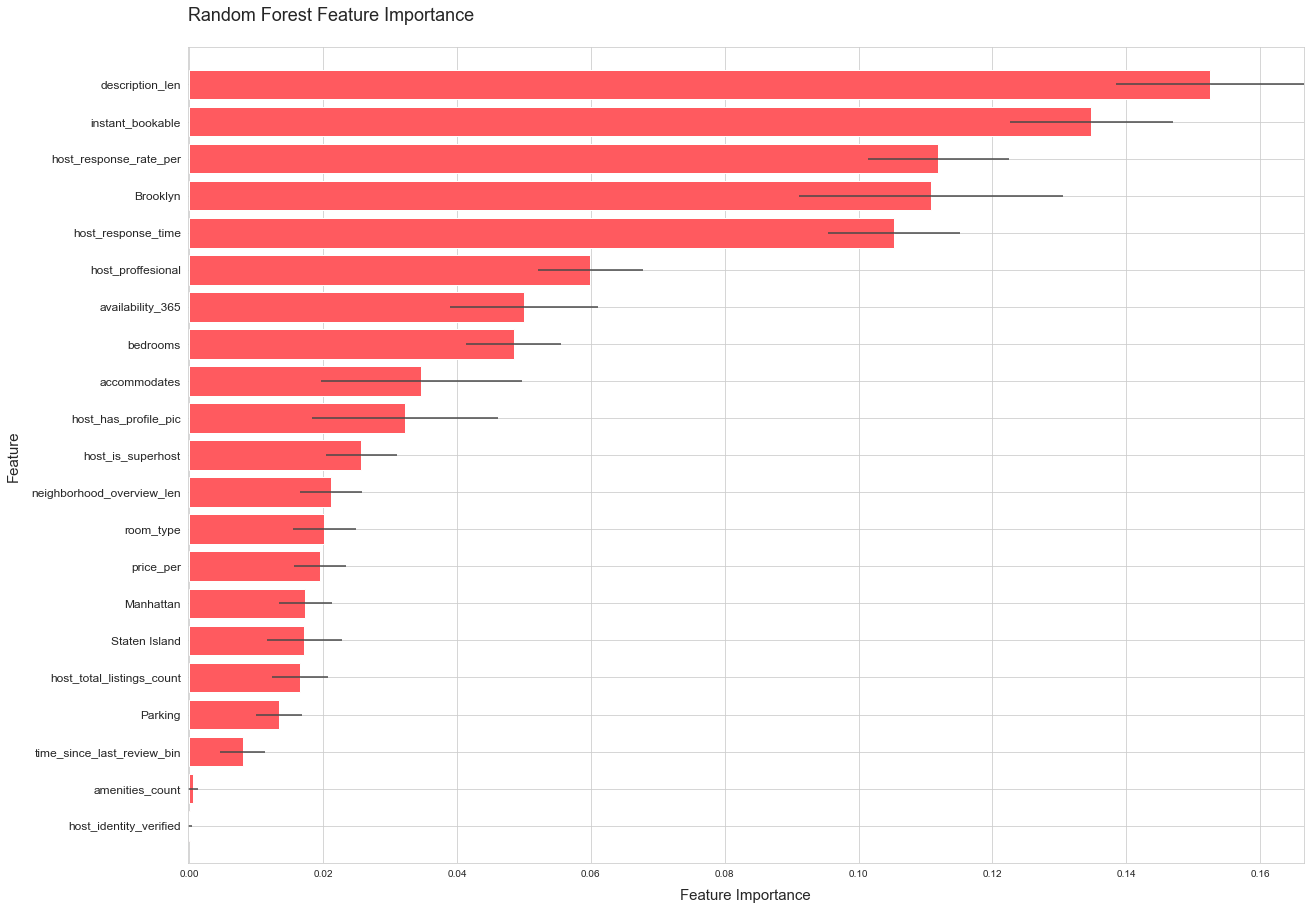

In [466]:
#Random Forest model 
rf_2 = RandomForestClassifier(max_depth = None, max_features= 'auto',min_samples_leaf = 5, 
                                       min_samples_split= 2, n_estimators=200,class_weight='balanced')
rf_2.fit(X2_train_scaled, y_train)

#prediction on testing data
rf2_pred = rf_2.predict(X2_test_scaled)

#performance score of the model, fbeta
rf2_fbeta = fbeta_score(y_test, rf2_pred, beta=0.75, average='weighted')
rf2_accuracy = balanced_accuracy_score(y_test, rf2_pred)

print('Random Forest2  | Fbeta score:  %.3f  \t' % rf2_fbeta)
print('Random Forest2  | Balanced Accuracy score:  %.3f  \t' % rf2_accuracy)


# Confusion matrix 
rf2_confusion = confusion_matrix(y_test, rf2_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, rf2_pred),
    display_labels=["average",  "high", "low"],
)

cmp.plot(ax=ax)
plt.savefig('rf2_conf.png',dpi =150)
plt.show()


# compute feature importance and std
importances2 = rf_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_2.estimators_],
             axis=0)
indices = np.argsort(importances2)

feature_list = [features2[indices[f]] for f in range(X2.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("Random Forest Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X2_test.shape[1]), importances2[indices],
       color = '#FF5A5F',ecolor ='#484848', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X2_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X2_test.shape[1]])
plt.savefig('rf2_feature.png',dpi =150)
plt.show()


In [316]:
importance_df2 = pd.DataFrame(importances2, index=ff, 
                      columns=["Importance"])
importance_df2.sort_values(by= 'Importance', ascending=False)

,Importance
host_verifications_count,0.148700
host_is_superhost,0.133303
bedrooms,0.108691
room_type,0.108088
instant_bookable,0.100628
time_since_last_review_bin,0.070481
Queens,0.058897
description_len,0.048484
host_has_profile_pic,0.031124
host_response_time,0.031111


C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:11:37] WARNING: ..\src\learner.cc:573: 
Parameters: { "feature_names", "n_iter_no_change" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoost2 |  Fbeta score:  0.586  	
XGBoost2 |  Balanced Accuracy score:  0.459  	


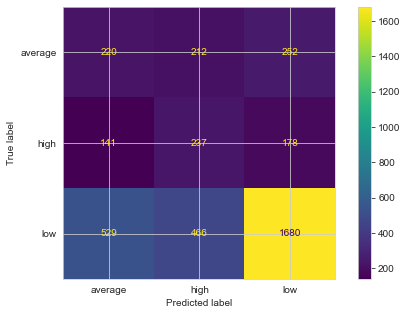

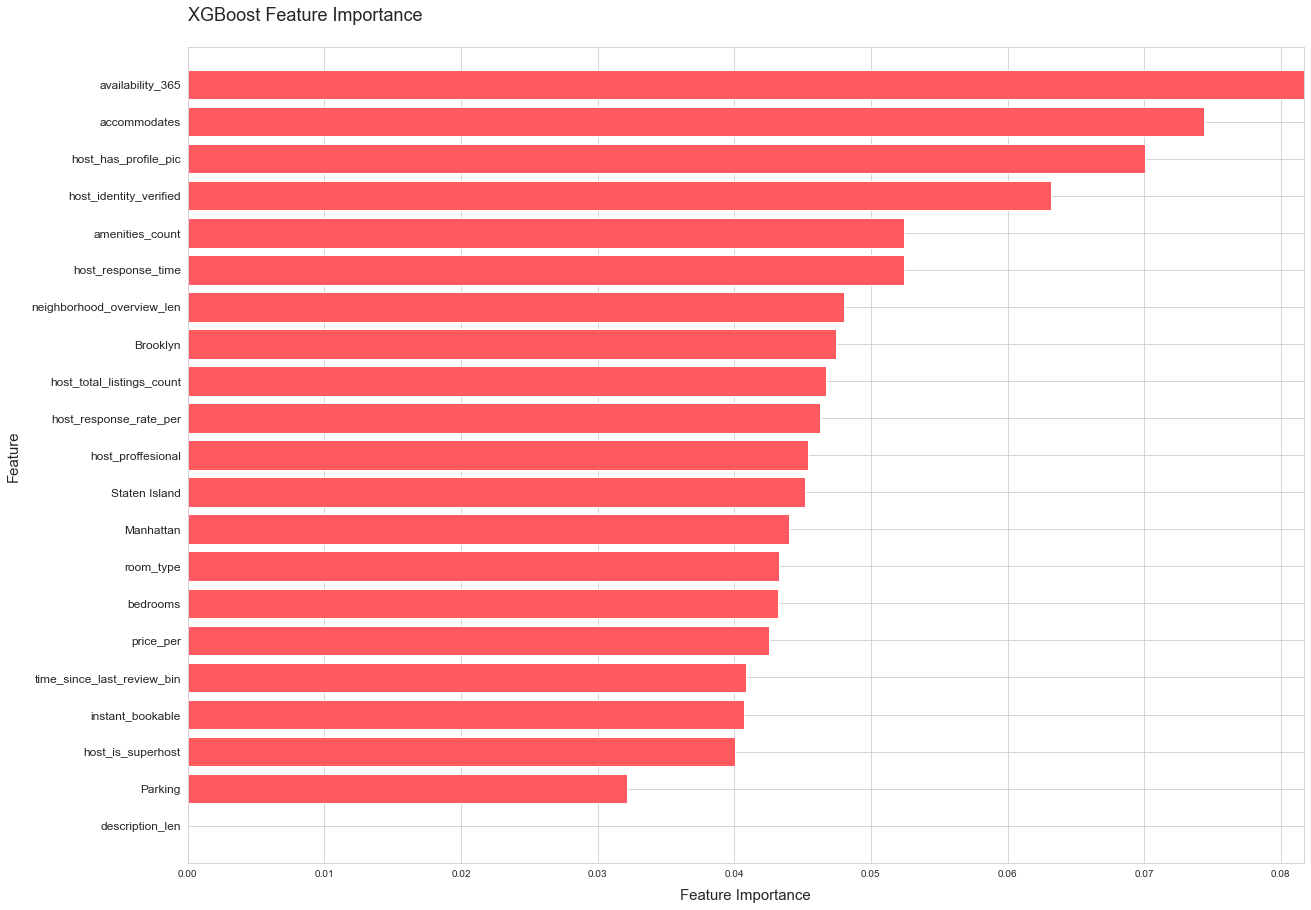

In [469]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=1000, learning_rate=0.1, 
                          max_depth=4, subsample=0.8, n_iter_no_change=2, verbosity=1,feature_names=full_model)
eval_set=[(X2_train_scaled,y_train),(X2_test_scaled,y_test)] #tracking train/validation error as we go
xgb2_fit = xgb_model.fit( 
                        X2_train_scaled, y_train, 
                        sample_weight = classes_weights, early_stopping_rounds = 50,eval_metric = 'merror',
                        eval_set = eval_set, verbose = False)

xgb2_preds = xgb_model.predict(X2_test_scaled, ntree_limit=xgb_model.best_ntree_limit)
    
# compute metric of interest
xgb2_fbeta = fbeta_score(y_test, xgb2_preds, beta=0.75, average='weighted') 
xgb2_accuracy =  balanced_accuracy_score(y_test,  xgb2_preds)

print('XGBoost2 |  Fbeta score:  %.3f  \t' % xgb2_fbeta)
print('XGBoost2 |  Balanced Accuracy score:  %.3f  \t' % xgb2_accuracy)



# Confusion matrix 
xgb2_confusion = confusion_matrix(y_test, xgb2_preds)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, xgb2_preds),
    display_labels=["average","high",'low'],
)

cmp.plot(ax=ax)
plt.savefig('xgb2_conf.png',dpi =150)
plt.show()


# compute feature importance and std
importances_xgb2 = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_],axis=0)
indices = np.argsort(importances_xgb2)

feature_list = [features2[indices[f]] for f in range(X2.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("XGBoost Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X2_test.shape[1]), importances_xgb2[indices],
       color = '#FF5A5F',ecolor ='#484848',  align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X2_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X2_test.shape[1]])
plt.savefig('xgboost_feature.png',dpi =150)

plt.show()


In [475]:
X2_test.shape[1]

21

Reduced model performs relatively better than the full model. XGboost is better than KNN, RF in balanced accuracy score, while  RF is better in Fbeta

In [423]:
#Grid Search for XGBoost

parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}


# First create the base model to tune
xgb_model = xgb.XGBClassifier(objective='multi:softprob', 
                           subsample=0.8, n_iter_no_change=2, verbosity=1,feature_names=full_model)
eval_set=[(X2_train_scaled,y_train),(X2_test_scaled,y_test)] #tracking train/validation error as we go


xgb2_grid = GridSearchCV(estimator = xgb_model, param_grid = parameters, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
xgb2_grid.fit( X2_train_scaled, y_train,sample_weight = classes_weights, 
              early_stopping_rounds = 50,eval_metric = 'merror',
                        eval_set = eval_set, verbose = False)

resultsxgb = xgb2_grid.cv_results_

# View best parameter
print('Best Score: ', xgb2_grid.best_score_)
print('Best Param: ', xgb2_grid.best_params_)



Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:46] WARNING: ..\src\learner.cc:573: 
Parameters: { "feature_names", "n_iter_no_change" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Score:  0.6091097760462402
Best Param:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 140}


C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoost |  Fbeta score:  0.599  	
XGBoost |  Balanced Accuracy score:  0.435  	


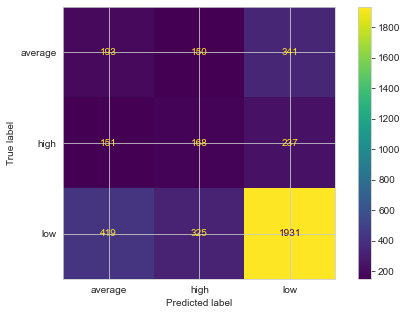

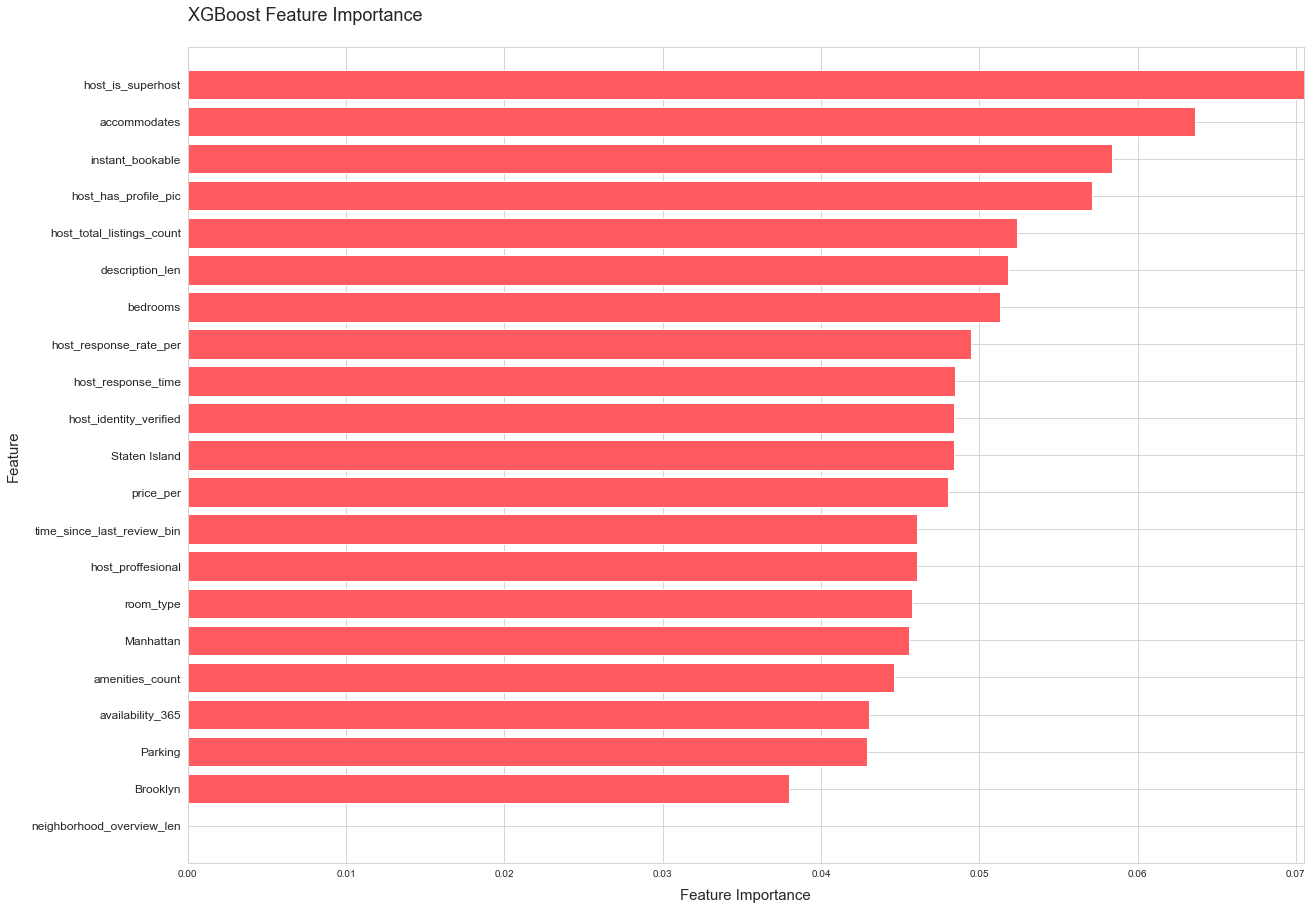

In [491]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=140, learning_rate=0.1, 
                          max_depth=8, subsample=0.8,  verbosity=1)
eval_set=[(X2_train_scaled,y_train),(X2_test_scaled,y_test)] #tracking train/validation error as we go
xgb3_fit = xgb_model.fit( 
                        X2_train_scaled, y_train, 
                        sample_weight = classes_weights, early_stopping_rounds = 50,eval_metric = 'merror',
                        eval_set = eval_set, verbose = False)

xgb3_preds = xgb_model.predict(X2_test_scaled, ntree_limit=xgb_model.best_ntree_limit)
    
# compute metric of interest
xgb3_fbeta = fbeta_score(y_test,xgb3_preds, beta=0.75, average='weighted') 
xgb3_accuracy =  balanced_accuracy_score(y_test, xgb3_preds)

print('XGBoost |  Fbeta score:  %.3f  \t' % xgb3_fbeta)
print('XGBoost |  Balanced Accuracy score:  %.3f  \t' % xgb3_accuracy)



# Confusion matrix 
xgb3_confusion = confusion_matrix(y_test, xgb3_preds)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, xgb3_preds),
    display_labels=["average", "high",'low'],
)

cmp.plot(ax=ax)
plt.savefig('xgb3_conf.png',dpi =150)
plt.show()


# compute feature importance and std
importances_xgb3 = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_],axis=0)
indices = np.argsort(importances_xgb3)

feature_list = [features2[indices[f]] for f in range(X2.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("XGBoost Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X2_test.shape[1]), importances_xgb3[indices],
       color = '#FF5A5F',ecolor ='#484848',  align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X2_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X2_test.shape[1]])
plt.savefig('xgboost_feature.png',dpi =300)

plt.show()


Grid Search doesn't help much to improve the scores.

In [425]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(lr, X2_train_scaled, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.342 (0.003)


In [426]:
#Grid Search for LogisticReg
params_lr = {'penalty' : ['none', 'l2'], 'C':[0.0, 0.0001, 0.001, 0.01, 0.1, 1.0] }

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')


lr_grid = GridSearchCV(estimator = lr_model, param_grid = params_lr, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
lr_grid.fit( X2_train_scaled, y_train)

resultslr = lr_grid.cv_results_

# View best parameter
print('Best Score: ', lr_grid.best_score_)
print('Best Param: ', lr_grid.best_params_)





Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.53695035        nan 0.53695035 0.52468285 0.53695035 0.52497565
 0.53695035 0.53473153 0.53695035 0.53673457 0.53695035 0.53695035]
  warnings.warn(
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [0.53732394        nan 0.53732394 0.52468285 0.53732394 0.52537867
 0.53732394 0.53491127 0.53732394 0.53702198 0.53732394 0.53733977]
  warnings.warn(
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.34229327        nan 0.34229327 0.33333333 0.34229327 0.33333455
 0.34229327 0.34049563 0.34229327 0.34213589 0.34229327 0.34229327]
  warnings.warn(
C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_se

Best Score:  0.5369503477227141
Best Param:  {'C': 0.0, 'penalty': 'none'}


C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


LR |  Fbeta score:  0.535  	
LR |  Balanced Accuracy score:  0.338  	


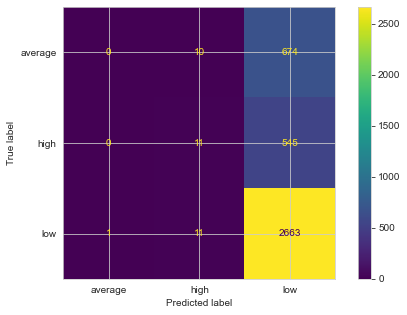

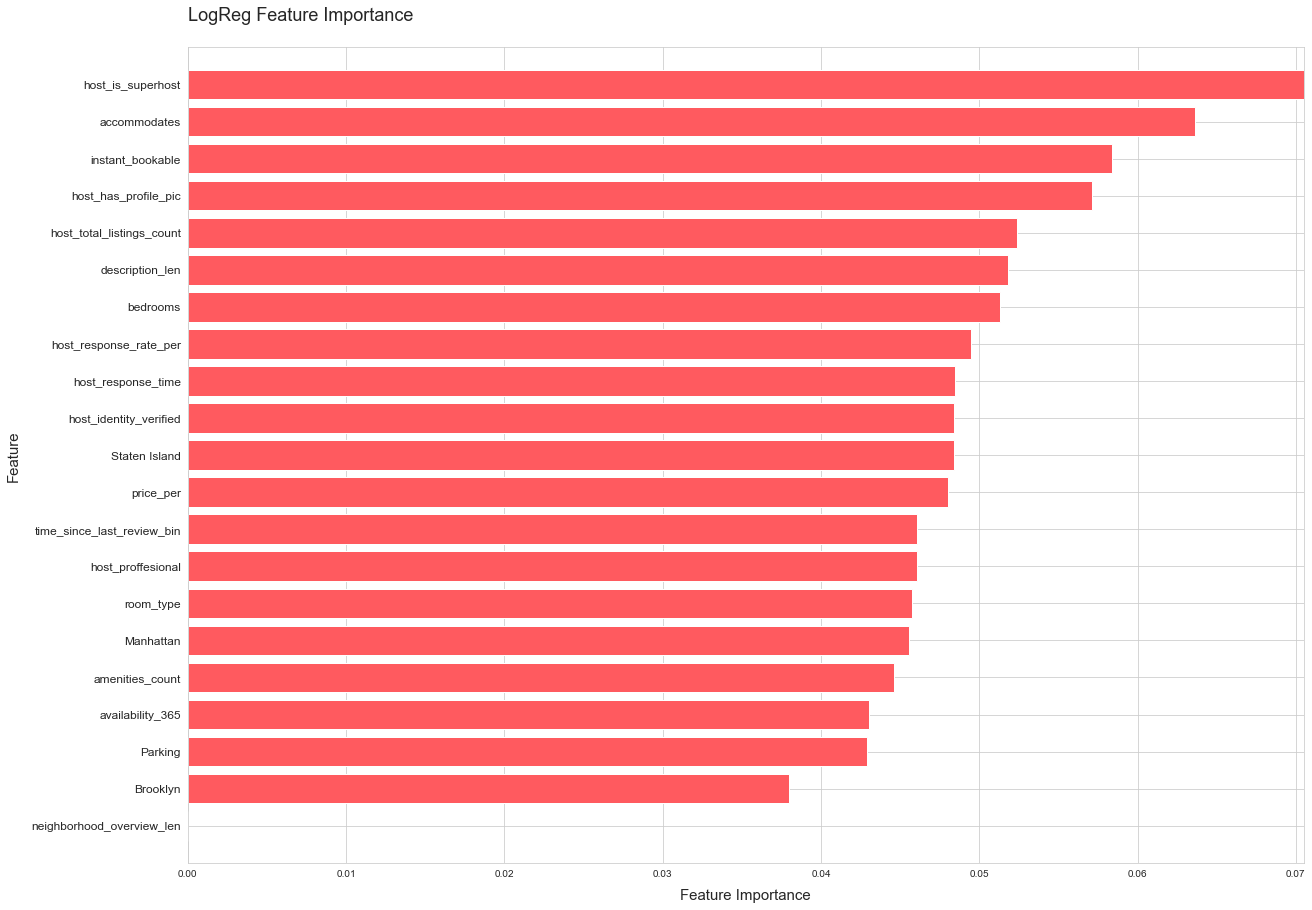

In [464]:
lr2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0, penalty = 'none')
lr2.fit(X2_train_scaled, y_train)
# logistic regression -
lr2_preds = lr2.predict(X2_test_scaled)

# compute metric of interest
lr2_fbeta = fbeta_score(y_test,lr2_preds, beta=0.75, average='weighted') 
lr2_accuracy =  balanced_accuracy_score(y_test, lr2_preds)

print('LR |  Fbeta score:  %.3f  \t' % lr2_fbeta)
print('LR |  Balanced Accuracy score:  %.3f  \t' % lr2_accuracy)



# Confusion matrix 
lr2_confusion = confusion_matrix(y_test, lr2_preds)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, lr2_preds),
    display_labels=["average",  "high", 'low'],
)

cmp.plot(ax=ax)
plt.savefig('lr2_conf.png',dpi =150)
plt.show()


# compute feature importance and std
importances_xgb3 = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_],axis=0)
indices = np.argsort(importances_xgb3)

feature_list = [features2[indices[f]] for f in range(X2.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("LogReg Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X2_test.shape[1]), importances_xgb3[indices],
       color = '#FF5A5F',ecolor ='#484848',  align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X2_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X2_test.shape[1]])
plt.savefig('lr_feature.png',dpi =150)

plt.show()


In [434]:
#reduced features based on the feature importance
features3= ['host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'room_type', 'accommodates',
       'bedrooms', 'price_per', 'availability_365', 
       'instant_bookable', 'description_len',
       'neighborhood_overview_len',
       'host_response_rate_per', 'host_proffesional',
       'Parking', 'time_since_last_review_bin','Brooklyn', 'Manhattan',
       'Staten Island']
X3 = listings[features3]

#split data and transform
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size = 0.2, random_state=42)


X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)



Random Forest3  | Fbeta score:  0.603  	
Random Forest3  | Balanced Accuracy score:  0.421  	


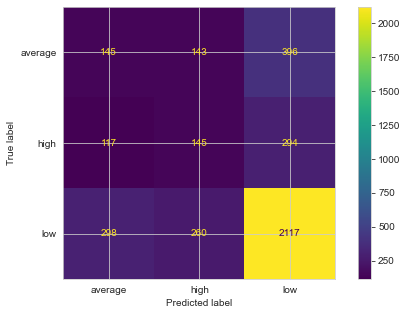

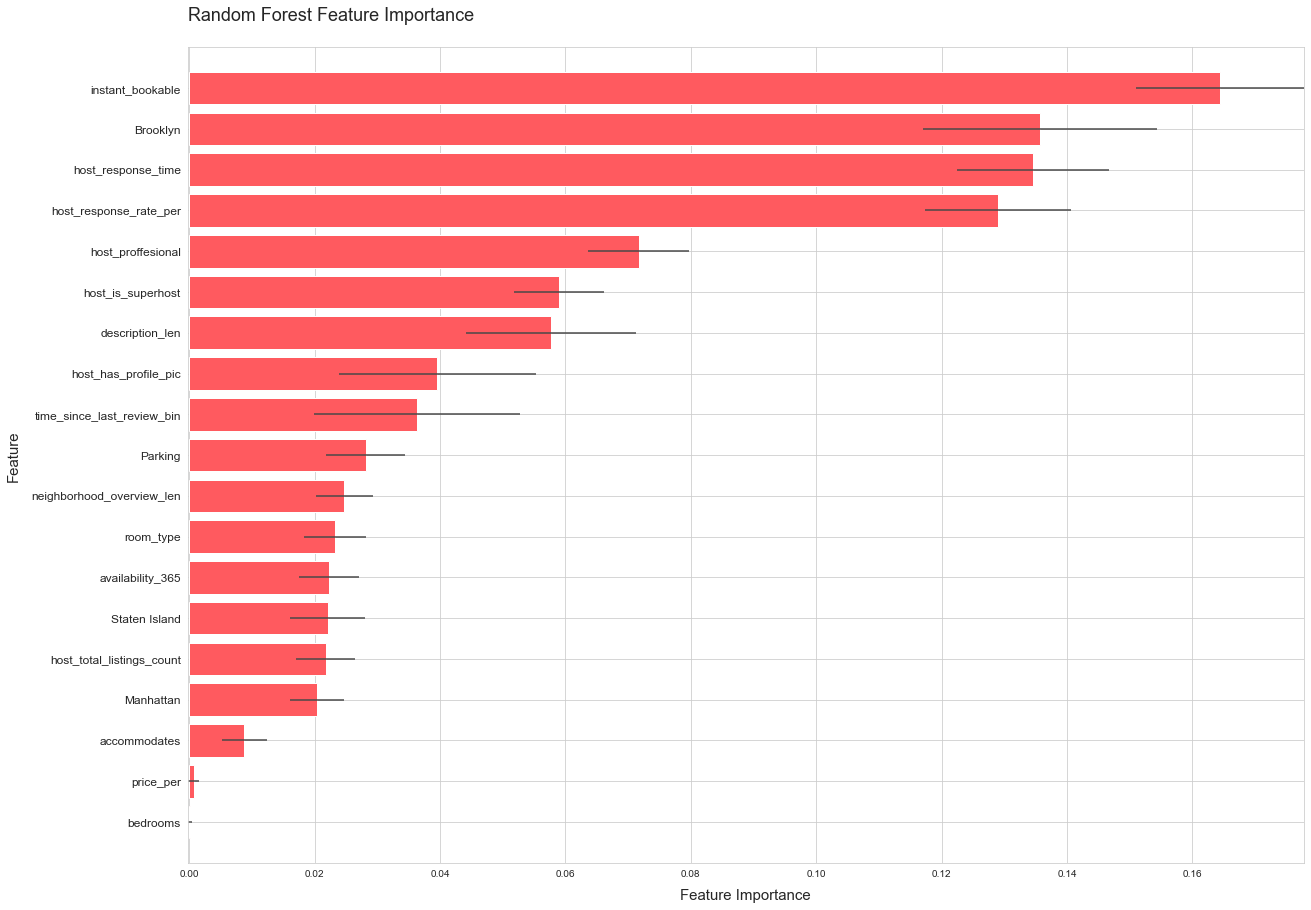

In [465]:
#Random Forest model Model3 
rf_3 = RandomForestClassifier(max_depth = None, max_features= 'auto',min_samples_leaf = 5, 
                                       min_samples_split= 2, n_estimators=200,class_weight='balanced')
rf_3.fit(X3_train_scaled, y_train)

#prediction on testing data
rf3_pred = rf_3.predict(X3_test_scaled)

#performance score of the model, fbeta
rf3_fbeta = fbeta_score(y_test, rf3_pred, beta=0.75, average='weighted')
rf3_accuracy = balanced_accuracy_score(y_test, rf3_pred)

print('Random Forest3  | Fbeta score:  %.3f  \t' % rf3_fbeta)
print('Random Forest3  | Balanced Accuracy score:  %.3f  \t' % rf3_accuracy)


# Confusion matrix 
rf3_confusion = confusion_matrix(y_test, rf3_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, rf3_pred),
    display_labels=["average",  "high", "low"],
)

cmp.plot(ax=ax)
plt.savefig('rf3_conf.png',dpi =150)
plt.show()


# compute feature importance and std
importances3 = rf_3.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_3.estimators_],
             axis=0)
indices = np.argsort(importances3)

feature_list = [features3[indices[f]] for f in range(X3.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("Random Forest Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X3_test.shape[1]), importances3[indices],
       color = '#FF5A5F',ecolor ='#484848', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X3_test.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X3_test.shape[1]])
plt.savefig('rf3_feature.png',dpi =150)
plt.show()


# Cross Validation

In [451]:
# define models to test
def get_models_final():
    # KNN
    models.append(KNeighborsClassifier(leaf_size= 1,n_neighbors= 10, weights= 'uniform'))
    names.append('KNN')
    # RF
    models.append(RandomForestClassifier(max_depth = None, max_features= 'auto',min_samples_leaf = 5, min_samples_split= 2, n_estimators=200,class_weight='balanced'))
    names.append('RF')
    #XGBoost
    models.append(xgb.XGBClassifier(objective='multi:softprob', n_estimators=140, learning_rate=0.1, max_depth=8, subsample=0.8,  verbosity=1))
    
    names.append('XGBoost')
    return models, names


In [457]:
# define models, Full model with Balanced Accuracy
#del models,names
models = []
names = []
models, names = get_models_final()
results_ac = list()

for i in range(len(models)):
    # evaluate the model and store results
    scores_ac = evaluate_model(X_train_scaled, y_train, models[i])
    results_ac.append(scores_ac)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores_ac), np.std(scores_ac) ))




>KNN 0.394 (0.007)
>RF 0.463 (0.009)
>XGBoost 0.411 (0.008)


In [458]:
# define models, Full model with Fbeta
del models,names
models = []
names = []
models_final, names_final = get_models_final()

results_fb =list()

for i in range(len(models_final)):
    # evaluate the model and store results
    scores_fb = evaluate_model_f(X_train_scaled, y_train, models_final[i])
    results_fb.append(scores_ac)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names_final[i], np.mean(scores_fb), np.std(scores_fb) ))




>KNN 0.599 (0.006)
>RF 0.638 (0.006)
>XGBoost 0.617 (0.007)


In [459]:
# define models, Reduced model with Balanced Accuracy
#del models,names
models = []
names = []
models, names = get_models_final()
results_ac = list()

for i in range(len(models)):
    # evaluate the model and store results
    scores_ac = evaluate_model(X2_train_scaled, y_train, models[i])
    results_ac.append(scores_ac)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores_ac), np.std(scores_ac) ))



>KNN 0.382 (0.007)
>RF 0.445 (0.006)
>XGBoost 0.388 (0.005)


In [460]:
# define models, Reduced model with Fbeta
del models,names
models = []
names = []
models_final, names_final = get_models_final()

results_fb =list()

for i in range(len(models_final)):
    # evaluate the model and store results
    scores_fb = evaluate_model_f(X2_train_scaled, y_train, models_final[i])
    results_fb.append(scores_ac)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names_final[i], np.mean(scores_fb), np.std(scores_fb) ))




>KNN 0.587 (0.006)
>RF 0.620 (0.004)
>XGBoost 0.596 (0.005)


## Other Models 

Split data in X and y and normalize data with StandardScaler: 

In [13]:
X_base = listings[['host_response_rate_per','amenities_count','neighborhood_overview_len','availability_365','host_proffesional']]
X_base.shape

(19573, 5)

In [17]:
#split data and transform
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y, test_size = 0.2, random_state=42)


X_base_train_scaled = scaler.fit_transform(X_base_train)
X_base_test_scaled = scaler.transform(X_base_test)


>SVC 0.333 (0.000)
>KNN 0.383 (0.009)
>BAG 0.366 (0.005)
>RF 0.364 (0.005)
>ET 0.370 (0.006)


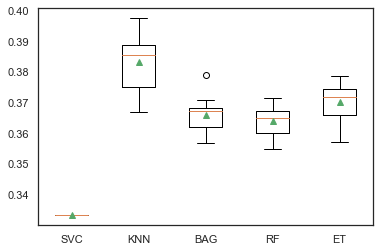

In [370]:
# define models
models, names = get_models()
results = list()

for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_base_train_scaled, y_base_train, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores) ))

# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>SVC 0.525 (0.000)
>KNN 0.578 (0.007)
>BAG 0.570 (0.006)
>RF 0.568 (0.006)
>ET 0.571 (0.005)


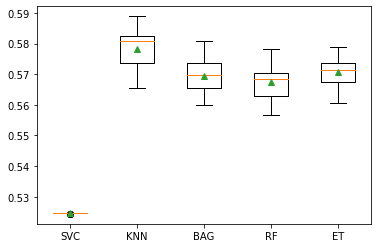

In [118]:

# define models
models, names = get_models()
results_f = list()

for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model_f(X_base_train_scaled, y_base_train, models[i])
    results_f.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores) ))

# plot the results
plt.boxplot(results_f, labels=names, showmeans=True)

plt.savefig('baselining_f.png',dpi =150)

## Grid Search with RandomForest for baseline model

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5, 50]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(param_grid)
ftwo_scorer = make_scorer(fbeta_score, beta=0.75, average='weighted')
accuracy_balanced = make_scorer(balanced_accuracy_score)

scoring = {"Fbeta": ftwo_scorer, "Balanced Accuracy": accuracy_balanced}


{'n_estimators': [100, 150, 200], 'max_features': ['auto'], 'max_depth': [10, 50, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 5, 50]}


In [424]:
#Grid Search for Random Forest

# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
rf_grid.fit(X_base_train_scaled, y_base_train)

results = rf_grid.cv_results_

# View best parameter
print('Best Score: ', rf_grid.best_score_)
print('Best Param: ', rf_grid.best_params_)



Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Score:  0.5746981325385447
Best Param:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [431]:
results_df.iloc[46,9]

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 150}

Parameters 
{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 150}
 produces relatively high Fbeta and balanced accuracy. 

Random Forest (n=150, min_samples_leaf = 5, min_samples_split= 5) | Baseline F1 beta score:  0.564  	
Random Forest (n=150, min_samples_leaf = 5, min_samples_split= 5) | Baseline Balanced Accuracy beta score:  0.410  	


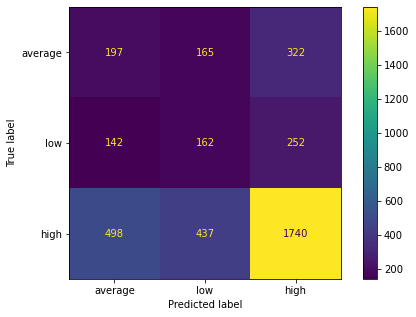

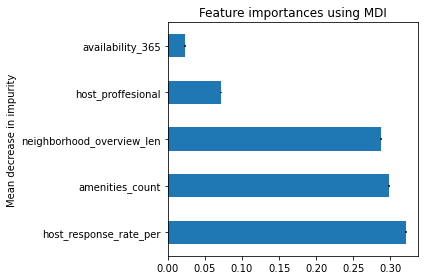

In [32]:
#Random Forest model with the selected params
rf_base = RandomForestClassifier(max_depth = None, max_features= 'auto',min_samples_leaf = 5, 
                                       min_samples_split= 5, n_estimators=150,class_weight='balanced')
rf_base.fit(X_base_train_scaled, y_base_train)

#prediction on testing data
rf_base_pred = rf_base.predict(X_base_test_scaled)

#performance score of the model, fbeta
rf_base_fbeta = fbeta_score(y_base_test, rf_base_pred, beta=0.75, average='weighted')
rf_base_accuracy = balanced_accuracy_score(y_base_test, rf_base_pred)

print('Random Forest (n=150, min_samples_leaf = 5, min_samples_split= 5) | Baseline F1 beta score:  %.3f  \t' % rf_base_fbeta)
print('Random Forest (n=150, min_samples_leaf = 5, min_samples_split= 5) | Baseline Balanced Accuracy beta score:  %.3f  \t' % rf_base_accuracy)


# Confusion matrix 
rf_base_confusion = confusion_matrix(y_base_test, rf_base_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_base_test, rf_base_pred),
    display_labels=["average",  "high","low"],
)

cmp.plot(ax=ax)
plt.savefig('rf_base.conf.png',dpi =150)
plt.show();

#Feature importance      
importances = rf_base.feature_importances_
indices = np.argsort(importances)
std = np.std([tree.feature_importances_ for tree in rf_base.estimators_], axis=0)

rf_importances = pd.Series(importances, index=['host_response_rate_per','amenities_count','neighborhood_overview_len','availability_365','host_proffesional'])

fig, ax = plt.subplots()
rf_importances.sort_values(ascending = False).plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()




plt.savefig('rf_base.png',dpi =150)




In [33]:
rf_importances.sort_values(ascending = False)

host_response_rate_per       0.320491
amenities_count              0.297547
neighborhood_overview_len    0.286907
host_proffesional            0.071324
availability_365             0.023731
dtype: float64

Availability_365 doesn't have much contribution to the model 

## Grid Search with SV for baseline model

In [35]:
# Create the random prama grid
param_grid_sv = {'C': [0.1,1, 10], 'gamma': [1,0.01, 'scale','auto']}


#Grid Search for SVC

# First create the base model to tune
svc = SVC(class_weight='balanced',kernel = 'linear')

svc_grid = GridSearchCV(estimator = svc, param_grid = param_grid_sv, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)

# Fit the random search model
svc_grid.fit(X_base_train_scaled, y_base_train)

results_svc_df = svc_grid.cv_results_

# View best parameter
print('Best Score: ', svc_grid.best_score_)
print('Best Param: ', svc_grid.best_params_)

results_svc_df = pd.DataFrame.from_dict(results_svc_df)

results_svc_df[['params','mean_test_Fbeta','rank_test_Fbeta','mean_test_Balanced Accuracy','rank_test_Balanced Accuracy']].sort_values(by=['rank_test_Fbeta', 'rank_test_Balanced Accuracy'], ascending =True)



Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Score:  0.5267571195461801
Best Param:  {'C': 1, 'gamma': 1}


,params,mean_test_Fbeta,rank_test_Fbeta,mean_test_Balanced Accuracy,rank_test_Balanced Accuracy
4,"{'C': 1, 'gamma': 1}",0.526757,1,0.403955,9
5,"{'C': 1, 'gamma': 0.01}",0.526757,1,0.403955,9
6,"{'C': 1, 'gamma': 'scale'}",0.526757,1,0.403955,9
7,"{'C': 1, 'gamma': 'auto'}",0.526757,1,0.403955,9
8,"{'C': 10, 'gamma': 1}",0.526741,5,0.404082,5
9,"{'C': 10, 'gamma': 0.01}",0.526741,5,0.404082,5
10,"{'C': 10, 'gamma': 'scale'}",0.526741,5,0.404082,5
11,"{'C': 10, 'gamma': 'auto'}",0.526741,5,0.404082,5
0,"{'C': 0.1, 'gamma': 1}",0.526623,9,0.404108,1
1,"{'C': 0.1, 'gamma': 0.01}",0.526623,9,0.404108,1


SVC (C= 10, gamma= 1) | Baseline F1 beta score:  0.520  	
SVC (C= 10, gamma= 1) | Baseline Balanced Accuracy beta score:  0.385  	


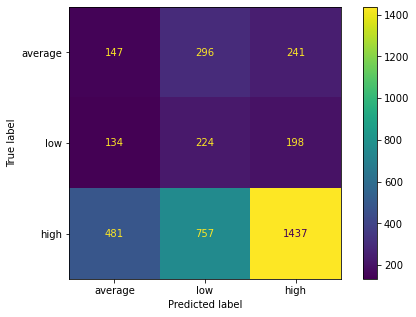

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [36]:
# SVC model with the selected params
svc_base = SVC(C= 10, gamma= 1, kernel = 'linear', class_weight='balanced')

svc_base.fit(X_base_train_scaled, y_base_train)

#prediction on testing data
svc_base_pred = svc_base.predict(X_base_test_scaled)

#performance score of the model, fbeta
svc_base_fbeta = fbeta_score(y_base_test, svc_base_pred, beta=0.75, average='weighted')
svc_base_accuracy = balanced_accuracy_score(y_base_test, svc_base_pred)

print('SVC (C= 10, gamma= 1) | Baseline F1 beta score:  %.3f  \t' % svc_base_fbeta)
print('SVC (C= 10, gamma= 1) | Baseline Balanced Accuracy beta score:  %.3f  \t' % svc_base_accuracy)


# Confusion matrix 
svc_base_confusion = confusion_matrix(y_base_test, svc_base_pred)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_base_test, svc_base_pred),
    display_labels=["average", "low", "high"],
)

cmp.plot(ax=ax)
plt.savefig('svc_base.conf.png',dpi =150)
plt.show();

#Feature importance 

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.savefig('svc_base.png',dpi =150)
    plt.show()

features_names = ['host_response_rate_per','amenities_count','neighborhood_overview_len','availability_365','host_proffesional']
f_importances(svc_base.coef_, features_names)







In [51]:
X_base_train_scaled.shape


(15658, 5)

In [47]:
coef = svc_base.coef_.ravel()
print(coef)

[-0.27271073 -0.14197407 -0.39297498  0.09228103  0.09469488  0.17953961
  0.04433696  0.1164409   0.11263534 -0.63947149  0.31568984  0.09100098
  0.24384075  0.11088016 -0.44106651]
